In [240]:
import duckdb
import pandas as pd
from statsbombpy import sb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gravis as gv
import networkx as nx

import scipy.stats as stats
import matplotlib.colors as mcolors
import matplotlib.cm as cm


# db yi güncelle sonra asist sayısını getir

In [241]:
con = duckdb.connect("example2.db")


In [242]:
passes = con.execute("SELECT * FROM events WHERE type = 'Pass'").df()


In [243]:

# columnsp = [
#     "match_id",
#     "competition",
#     "home_team",
#     "home_score",
#     "away_team",
#     "away_score",
#     "referee",
#     "team",
#     "possession",
#     "possession_time",
#     "minute",
#     "timestamp",
#     "player",
#     "position",
#     "position_most_played",
#     "x",
#     "y",
#     "pass_end_x",
#     "pass_end_y",
#     "pass_length",
#     "pass_recipient",
#     "pass_recipient_id",
#     "position_re_most_played",
#     "pass_recipient_position",
#     "player_shotFromPass",
#     "shot_type_shotFromPass",
#     "shot_outcome_shotFromPass",
#     "shot_statsbomb_xg_shotFromPass",
#     "pass_succes",
#     "pass_outcome",
#     "f3rd_pass",
#     "pass_progression",
#     "shot_assisted_pass",
#     "goal_assisted_pass",
#     "cross",
#     "box_pass",
#     "SequenceID",
#     "InSequenceID",
#     "SequenceType",
#     "SequenceXG",
#     "SequenceBuildUpXG",
#     "time_past"
# ]

# pdf=passes[columnsp]



In [244]:

columnsp = [
    "match_id",
    "competition",
    "home_team",
    "home_score",
    "away_team",
    "away_score",
    "referee",
    "team",
    "possession",
    "possession_time",
    "minute",
    "timestamp",
    "player",
    "position",
    "position_most_played",
    "x",
    "y",
    "pass_end_x",
    "pass_end_y",
    "pass_length",
    "pass_recipient",
    "pass_recipient_id",
    "position_re_most_played",
    "pass_recipient_position",
    "player_shotFromPass",
    "shot_type_shotFromPass",
    "shot_outcome_shotFromPass",
    "shot_statsbomb_xg_shotFromPass",
    'SequenceXG',
    "SequenceBuildUpXG",
    "pass_succes",
    "pass_outcome",
]

pdf=passes[columnsp]



In [245]:
pdf.head(5)

match_id      competition   home_team  home_score away_team  away_score  \
0   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
1   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
2   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
3   3825848  Spain - La Liga  Levante UD           2     Eibar           2   
4   3825848  Spain - La Liga  Levante UD           2     Eibar           2   

  referee        team  possession  possession_time  ...  \
0    None       Eibar         145           29.612  ...   
1    None  Levante UD         146            0.123  ...   
2    None       Eibar           2           19.824  ...   
3    None       Eibar           2           19.824  ...   
4    None       Eibar           2           19.824  ...   

   position_re_most_played pass_recipient_position player_shotFromPass  \
0                     None                    None                None   
1                     None                    None                None   
2           Center Forward                    None                None   
3  Left Defensive Midfield                    None                None   
4         Left Center Back                    None                None   

  shot_type_shotFromPass shot_outcome_shotFromPass  \
0                   None                      None   
1                   None                      None   
2                   None                      None   
3                   None                      None   
4                   None                      None   

   shot_statsbomb_xg_shotFromPass  SequenceXG  SequenceBuildUpXG  pass_succes  \
0                             NaN        None               None          NaN   
1                             NaN        None               None          NaN   
2                             NaN                                        True   
3                             NaN                                        True   
4                             NaN                                        True   

       pass_outcome  
0  Injury Clearance  
1  Injury Clearance  
2              None  
3              None  
4              None  

[5 rows x 32 columns]

In [246]:
pdf["SequenceXG"] = pd.to_numeric(pdf["SequenceXG"], errors="coerce")
pdf["SequenceBuildUpXG"] = pd.to_numeric(pdf["SequenceBuildUpXG"], errors="coerce")


/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_2460/2228938483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["SequenceXG"] = pd.to_numeric(pdf["SequenceXG"], errors="coerce")
/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_2460/2228938483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["SequenceBuildUpXG"] = pd.to_numeric(pdf["SequenceBuildUpXG"], errors="coerce")


In [308]:
def network_creation(match_pass_data):
    # Create a copy of the match_pass_data to avoid modifying the original DataFrame
    df = match_pass_data.copy()

    # Only keep successful passes with valid recipients
    df = df[(df['pass_succes']) & (df['pass_recipient'].notna())]

    # Initialize a directed graph
    G = nx.DiGraph()

    # Add edges with weights to the graph
    for _, row in df.iterrows():
        if G.has_edge(row['player'], row['pass_recipient']):
            # Increment weight if the edge already exists
            G[row['player']][row['pass_recipient']]['weight'] += 1
        else:
            # Add edge with an initial weight of 1
            G.add_edge(row['player'], row['pass_recipient'], weight=1)

    # Calculate centrality measures
    try:
        degree_centrality = nx.degree_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
        closeness_centrality = nx.closeness_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
    except nx.PowerIterationFailedConvergence:
        print("Error: Eigenvector centrality did not converge. Check the graph structure.")

    # Convert centrality measures to DataFrames
    degree_c = pd.DataFrame(list(degree_centrality.items()), columns=['player', 'degree_c'])
    eigen_c = pd.DataFrame(list(eigenvector_centrality.items()), columns=['player', 'eigen_c'])
    closeness_c = pd.DataFrame(list(closeness_centrality.items()), columns=['player', 'closeness_c'])
    betweenness_c = pd.DataFrame(list(betweenness_centrality.items()), columns=['player', 'betweenness_c'])
    
    #print(df["pass_succes"].unique())    # Perform left joins with the main DataFrame to add centrality measures
    
    result_df = df.merge(degree_c, on='player', how='left')
    result_df = result_df.merge(eigen_c, on='player', how='left')
    result_df = result_df.merge(closeness_c, on='player', how='left')
    result_df = result_df.merge(betweenness_c, on='player', how='left')
    #print(result_df["pass_succes"].unique())    # Perform left joins with the main DataFrame to add centrality measures


    # Return the graph and the updated DataFrame
    return G, result_df




def network_viz(df, G):
    # Compute player positions
    pass_positions = df[['player', 'x', 'y']].rename(columns={'x': 'pos_x', 'y': 'pos_y'})
    receive_positions = df[['pass_recipient', 'pass_end_x', 'pass_end_y']].rename(
        columns={'pass_recipient': 'player', 'pass_end_x': 'pos_x', 'pass_end_y': 'pos_y'}
    )

    # Combine pass and receive positions
    all_positions = pd.concat([pass_positions, receive_positions], ignore_index=True)

    # Calculate average positions
    average_positions_df = all_positions.groupby('player')[['pos_x', 'pos_y']].mean()

    # Convert to dictionary for NetworkX
    average_positions = average_positions_df.apply(lambda row: (row['pos_x'], row['pos_y']), axis=1).to_dict()

    # Node size calculation (based on degree centrality)
    centrality = nx.degree_centrality(G)  # Calculate centrality
    min_size, max_size = 10, 100  # Desired size range
    min_centrality = min(centrality.values(), default=0)
    max_centrality = max(centrality.values(), default=1)

    node_sizes = [
        min_size + ((centrality[node] - min_centrality) / (max_centrality - min_centrality)) * (max_size - min_size)
        for node in G.nodes
    ]

    # Node color calculation (based on SequenceXG)
    grouped = df.groupby('player')['SequenceXG'].sum().reset_index()
    grouped.set_index('player', inplace=True)
    norm = mcolors.Normalize(vmin=grouped['SequenceXG'].min(), vmax=grouped['SequenceXG'].max())
    colormap = cm.viridis
    node_colors = [
        mcolors.to_hex(colormap(norm(grouped.loc[node]['SequenceXG']))) if node in grouped.index else '#808080'
        for node in G.nodes
    ]

    # Get edge weights for visualization (scaled for thickness)
    weights = [data.get('weight', 1) * 0.01 for _, _, data in G.edges(data=True)]

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))

    # Add background field image
    try:
        field_image = plt.imread("pitch.png")  # Path to the football field image
        ax.imshow(field_image, extent=[0, 120, 80, 0], zorder=0)  # Adjust to field dimensions
    except FileNotFoundError:
        print("Field image not found. Please ensure 'pitch.png' is in the correct path.")

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, average_positions, node_size=node_sizes, node_color=node_colors, ax=ax, alpha=0.9)
    nx.draw_networkx_labels(G, average_positions, font_size=8, font_color="black", ax=ax)
    nx.draw_networkx_edges(
        G,
        average_positions,
        edge_color="gray",
        width=weights,
        arrowstyle='->',
        arrowsize=10,
        ax=ax
    )

    # Add colorbar for node colors
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('SequenceXG', rotation=90, labelpad=10)

    # Axis settings
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_axis_off()  # Hide axes
    ax.invert_yaxis()  # Invert y-axis to match football field orientation

    plt.title("Passing Network")
    plt.show()




def agg_players(data,flag=0):
    # flag 0: takım
    # flag 1: oyuncu takım
    # flag 2: mevki takım  
    arr=[]
    if flag==0:
        arr.append("team")
    elif flag==1:
        arr.append("player")
        arr.append("team")
    elif flag==2:
        arr.append("position_most_played")
        arr.append("team")

    # Aggregation dictionary
    agg_dict = {
        'position': lambda x: x.mode()[0] if not x.mode().empty else None,
        'pass_length': 'mean',
        'pass_progression': 'mean',
        "possession_time":['sum',"mean"],
        'InSequenceID': 'mean',
        'time_past': 'mean',
        'degree_c': 'mean',
        'eigen_c': 'mean',
        'closeness_c': 'mean',
        'betweenness_c': 'mean',
        'pass_recipient': lambda x: x.mode()[0] if not x.mode().empty else None,
        'pass_recipient_position': lambda x: x.mode()[0] if not x.mode().empty else None,
        'shot_statsbomb_xg_shotFromPass': 'sum',
        'SequenceXG': 'sum',
        'SequenceBuildUpXG': 'sum',
        'pass_succes': "count",
        'f3rd_pass': 'sum',
        'shot_assisted_pass': 'sum',
        'goal_assisted_pass': 'sum',
        'cross': 'sum',
        'box_pass': 'sum',
        'match_id': 'mean'  # Unique count of match IDs

    }

    by_player = data.groupby(arr).agg(agg_dict)

    by_player.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in by_player.columns]

    # Reset the index for better readability
    by_player = by_player.reset_index()

    # Calculate pass success per total possession time
    #by_player['pass_rate'] = by_player['pass_succes_sum'] / by_player['possession_time_sum']

    return by_player





### Network oluşturma

In [248]:
# Dictionaries to store data
team_graphs = {}      # To store NetworkX graphs
team_dataframes = {}  # To store DataFrames
all_teams_dataframe = pd.DataFrame()

# Iterate over unique teams and populate the dictionaries
for team in pdf.team.unique():
    season_network, season_network_DF = network_creation(pdf[pdf["team"] == team])
    team_graphs[team] = season_network
    team_dataframes[team] = season_network_DF
    all_teams_dataframe = pd.concat([all_teams_dataframe, season_network_DF], ignore_index=True)

# Access data by team name
team_name = "Barcelona"  # Replace with the desired team name



In [249]:
df = team_dataframes[team_name][["player","match_id","degree_c", "eigen_c", "closeness_c", "betweenness_c","shot_statsbomb_xg_shotFromPass","SequenceBuildUpXG"]]
df

player  match_id  degree_c   eigen_c  \
0      Neymar da Silva Santos Junior   3825660  1.833333  0.230461   
1           Luis Alberto Suárez Díaz   3825660  1.708333  0.226338   
2           Sergio Busquets i Burgos   3825660  1.750000  0.221558   
3               Andrés Iniesta Luján   3825660  1.708333  0.221558   
4                     Jérémy Mathieu   3825660  1.708333  0.213598   
...                              ...       ...       ...       ...   
22127                   Ivan Rakitić    266557  1.875000  0.226338   
22128       Sergio Busquets i Burgos    266557  1.750000  0.221558   
22129               Jordi Alba Ramos    266557  1.833333  0.214830   
22130       Luis Alberto Suárez Díaz    266557  1.708333  0.226338   
22131       Sergio Busquets i Burgos    266557  1.750000  0.221558   

       closeness_c  betweenness_c  shot_statsbomb_xg_shotFromPass  \
0         0.960000       0.013850                             NaN   
1         0.923077       0.007705                             NaN   
2         0.888889       0.004933                             NaN   
3         0.888889       0.003409                             NaN   
4         0.857143       0.003409                             NaN   
...            ...            ...                             ...   
22127     0.923077       0.042719                             NaN   
22128     0.888889       0.004933                             NaN   
22129     0.888889       0.016070                             NaN   
22130     0.923077       0.007705                             NaN   
22131     0.888889       0.004933                             NaN   

       SequenceBuildUpXG  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
22127                NaN  
22128                NaN  
22129                NaN  
22130                0.0  
22131                NaN  

[22132 rows x 8 columns]

In [344]:
df = all_teams_dataframe[["player",'team',"match_id","degree_c", "eigen_c", "closeness_c", "betweenness_c",'shot_outcome_shotFromPass',"shot_statsbomb_xg_shotFromPass","SequenceBuildUpXG", 'SequenceXG' ]]
df

player       team  match_id  degree_c   eigen_c  \
0        Adrián González Morales      Eibar   3825848  1.846154  0.229477   
1           Borja González Tomás      Eibar   3825848  1.730769  0.235909   
2         Daniel García Carrillo      Eibar   3825848  1.884615  0.234545   
3              Aleksandar Pantić      Eibar   3825848  1.615385  0.199169   
4        Mauro Javier Dos Santos      Eibar   3825848  1.846154  0.227825   
...                          ...        ...       ...       ...       ...   
276758              Ivan Rakitić  Barcelona    266557  1.875000  0.226338   
276759  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   
276760          Jordi Alba Ramos  Barcelona    266557  1.833333  0.214830   
276761  Luis Alberto Suárez Díaz  Barcelona    266557  1.708333  0.226338   
276762  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   

        closeness_c  betweenness_c shot_outcome_shotFromPass  \
0          0.928571       0.037141                      None   
1          0.962963       0.018717                      None   
2          0.928571       0.029844                      None   
3          0.787879       0.005694                      None   
4          0.896552       0.024964                      None   
...             ...            ...                       ...   
276758     0.923077       0.042719                      None   
276759     0.888889       0.004933                      None   
276760     0.888889       0.016070                      None   
276761     0.923077       0.007705                      None   
276762     0.888889       0.004933                      None   

        shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  
0                                  NaN                NaN         NaN  
1                                  NaN                NaN         NaN  
2                                  NaN                NaN         NaN  
3                                  NaN                NaN         NaN  
4                                  NaN                NaN         NaN  
...                                ...                ...         ...  
276758                             NaN                NaN         NaN  
276759                             NaN                NaN         NaN  
276760                             NaN                NaN         NaN  
276761                             NaN                0.0         NaN  
276762                             NaN                NaN         NaN  

[276763 rows x 11 columns]

In [345]:
# Assign 1 if the value is 'Goal', otherwise 0
df['shot_outcome_shotFromPass_binary'] = df['shot_outcome_shotFromPass'].apply(lambda x: 1 if x == 'Goal' else 0)
df

/var/folders/6j/1nsywzcs1v5_6gn_3972hssr0000gn/T/ipykernel_2460/3154426905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shot_outcome_shotFromPass_binary'] = df['shot_outcome_shotFromPass'].apply(lambda x: 1 if x == 'Goal' else 0)


player       team  match_id  degree_c   eigen_c  \
0        Adrián González Morales      Eibar   3825848  1.846154  0.229477   
1           Borja González Tomás      Eibar   3825848  1.730769  0.235909   
2         Daniel García Carrillo      Eibar   3825848  1.884615  0.234545   
3              Aleksandar Pantić      Eibar   3825848  1.615385  0.199169   
4        Mauro Javier Dos Santos      Eibar   3825848  1.846154  0.227825   
...                          ...        ...       ...       ...       ...   
276758              Ivan Rakitić  Barcelona    266557  1.875000  0.226338   
276759  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   
276760          Jordi Alba Ramos  Barcelona    266557  1.833333  0.214830   
276761  Luis Alberto Suárez Díaz  Barcelona    266557  1.708333  0.226338   
276762  Sergio Busquets i Burgos  Barcelona    266557  1.750000  0.221558   

        closeness_c  betweenness_c shot_outcome_shotFromPass  \
0          0.928571       0.037141                      None   
1          0.962963       0.018717                      None   
2          0.928571       0.029844                      None   
3          0.787879       0.005694                      None   
4          0.896552       0.024964                      None   
...             ...            ...                       ...   
276758     0.923077       0.042719                      None   
276759     0.888889       0.004933                      None   
276760     0.888889       0.016070                      None   
276761     0.923077       0.007705                      None   
276762     0.888889       0.004933                      None   

        shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  \
0                                  NaN                NaN         NaN   
1                                  NaN                NaN         NaN   
2                                  NaN                NaN         NaN   
3                                  NaN                NaN         NaN   
4                                  NaN                NaN         NaN   
...                                ...                ...         ...   
276758                             NaN                NaN         NaN   
276759                             NaN                NaN         NaN   
276760                             NaN                NaN         NaN   
276761                             NaN                0.0         NaN   
276762                             NaN                NaN         NaN   

        shot_outcome_shotFromPass_binary  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0  
...                                  ...  
276758                                 0  
276759                                 0  
276760                                 0  
276761                                 0  
276762                                 0  

[276763 rows x 12 columns]

In [346]:
# Aggregation dictionary
agg_dict = {
    'degree_c': 'mean',
    'eigen_c': 'mean',
    "closeness_c":"mean",
    'betweenness_c': 'mean',
    'shot_statsbomb_xg_shotFromPass': 'sum',
    'SequenceBuildUpXG': 'sum',
    'SequenceXG' : 'sum',
    'shot_outcome_shotFromPass_binary': 'sum'

}

by_player_match = df.groupby(["player",'team',"match_id"]).agg(agg_dict)
by_player_match = by_player_match.reset_index()

agg_dict = {
    'degree_c': 'mean',
    'eigen_c': 'mean',
    "closeness_c":"mean",
    'betweenness_c': 'mean',
    'shot_statsbomb_xg_shotFromPass': 'sum',
    'SequenceBuildUpXG': 'sum',
    'SequenceXG' : 'sum',
    'shot_outcome_shotFromPass_binary': 'sum'


}
by_player = by_player_match.groupby("player").agg(agg_dict)
by_player = by_player.reset_index()
by_player

player  degree_c   eigen_c  closeness_c  \
0                   Abdoul Karim Yoda  1.615385  0.210081     0.866667   
1                  Abdoulaye Doucouré  1.370370  0.171872     0.750000   
2           Abraham González Casanova  1.560000  0.189383     0.833333   
3         Adalberto Peñaranda Maestre  1.592593  0.196177     0.818182   
4    Aderllan Leandro de Jesus Santos  1.655172  0.188509     0.828571   
..                                ...       ...       ...          ...   
533              Íñigo Lekue Martínez  1.875000  0.221813     0.960000   
534            Íñigo Martínez Berridi  1.730769  0.211547     0.866667   
535               Óliver Torres Muñoz  1.833333  0.224816     0.923077   
536          Óscar Esau Duarte Gaitán  1.440000  0.176130     0.781250   
537             Óscar de Marcos Arana  1.958333  0.225568     1.000000   

     betweenness_c  shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  \
0         0.002409                        0.434431           2.249535   
1         0.001477                        0.615640           2.097704   
2         0.002851                        2.334519           4.195373   
3         0.004457                        2.263150           0.617804   
4         0.029203                        0.030815           1.803040   
..             ...                             ...                ...   
533       0.007572                        0.585020           1.930899   
534       0.008227                        0.286110           7.190235   
535       0.009136                        1.185552           2.849200   
536       0.003070                        0.069180           1.681381   
537       0.016095                        1.588619           7.554005   

     SequenceXG  shot_outcome_shotFromPass_binary  
0      2.683965                                 0  
1      2.713344                                 2  
2      5.983739                                 1  
3      2.880954                                 3  
4      1.833855                                 0  
..          ...                               ...  
533    2.515919                                 0  
534    7.476345                                 0  
535    3.977295                                 2  
536    1.750561                                 1  
537    9.142624                                 3  

[538 rows x 9 columns]

In [253]:
# Display basic information
by_player.info()  # Data types and non-null counts
  # First few rows of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   player                            538 non-null    object 
 1   degree_c                          538 non-null    float64
 2   eigen_c                           538 non-null    float64
 3   closeness_c                       538 non-null    float64
 4   betweenness_c                     538 non-null    float64
 5   shot_statsbomb_xg_shotFromPass    538 non-null    float64
 6   SequenceBuildUpXG                 538 non-null    float64
 7   SequenceXG                        538 non-null    float64
 8   shot_outcome_shotFromPass_binary  538 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 38.0+ KB


In [254]:
by_player.describe()  # Summary statistics for numerical columns


degree_c     eigen_c  closeness_c  betweenness_c  \
count  538.000000  538.000000   538.000000     538.000000   
mean     1.512259    0.185666     0.824043       0.009849   
std      0.416069    0.049297     0.124646       0.010296   
min      0.068966    0.004879     0.397260       0.000000   
25%      1.346154    0.169246     0.750000       0.002380   
50%      1.653846    0.206023     0.852941       0.007476   
75%      1.807692    0.219262     0.923077       0.014048   
max      2.000000    0.235939     1.000000       0.090347   

       shot_statsbomb_xg_shotFromPass  SequenceBuildUpXG  SequenceXG  \
count                      538.000000         538.000000  538.000000   
mean                         1.251082           3.860859    5.083844   
std                          1.743566           4.824383    5.980295   
min                          0.000000           0.000000    0.000000   
25%                          0.066547           0.796685    1.075338   
50%                          0.580566           2.485082    3.196631   
75%                          1.801663           5.092442    6.877135   
max                         13.657177          39.480676   44.084789   

       shot_outcome_shotFromPass_binary  
count                        538.000000  
mean                           1.342007  
std                            2.185559  
min                            0.000000  
25%                            0.000000  
50%                            0.000000  
75%                            2.000000  
max                           15.000000

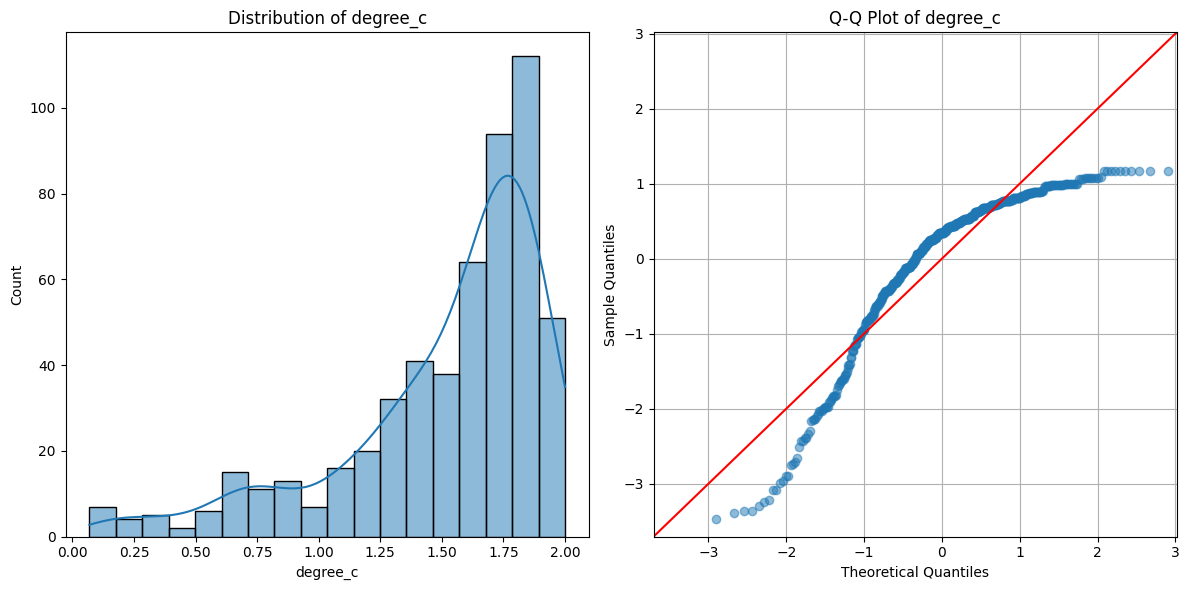

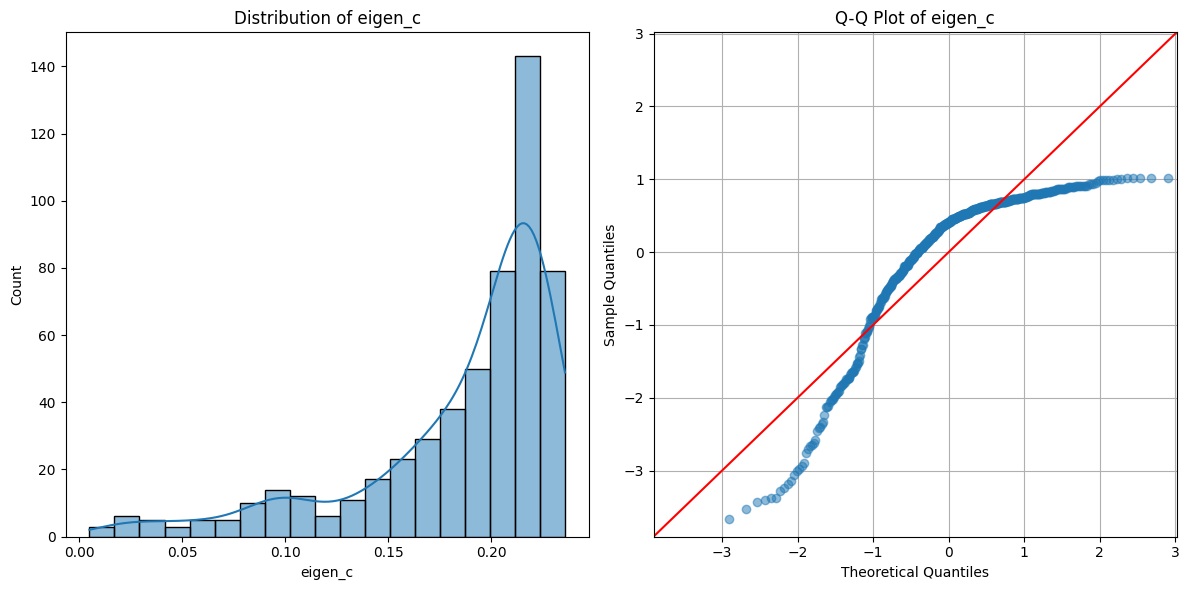

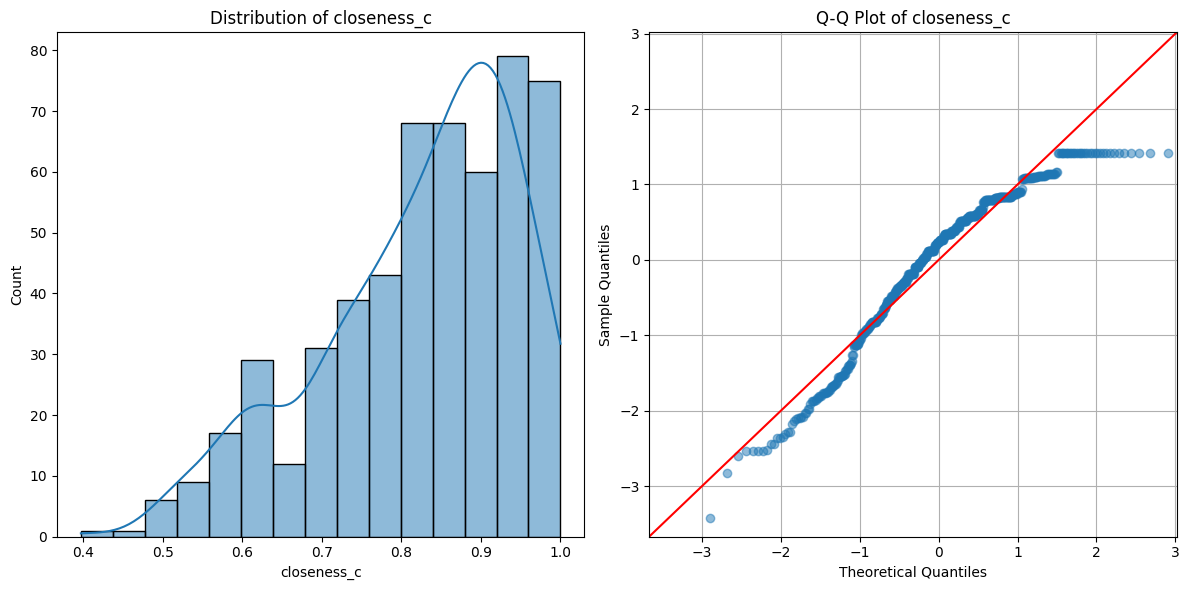

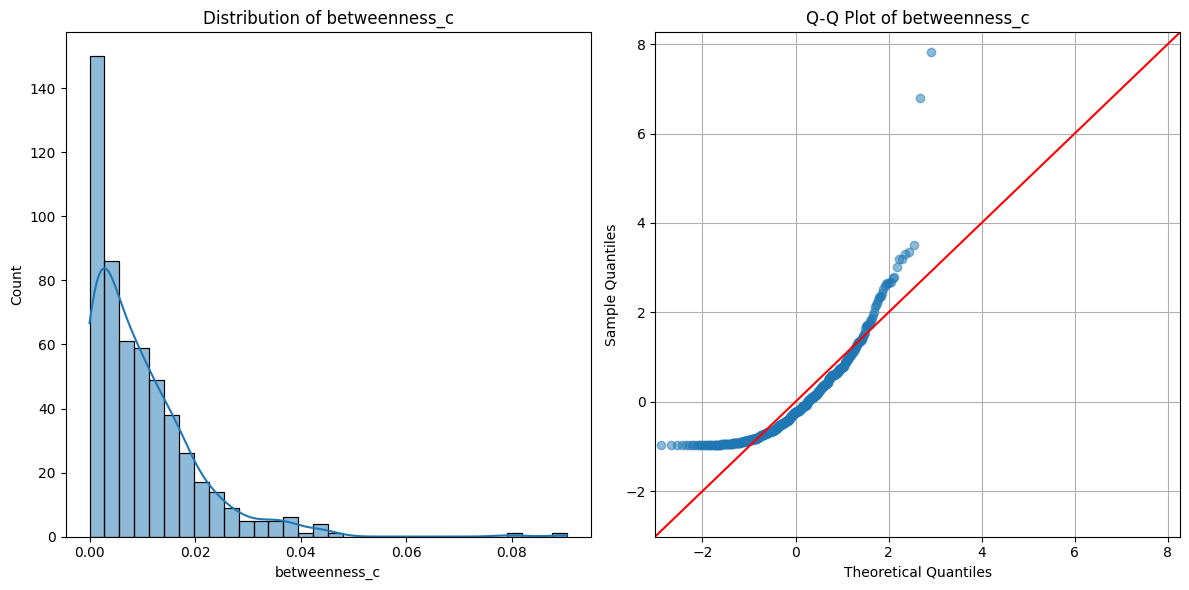

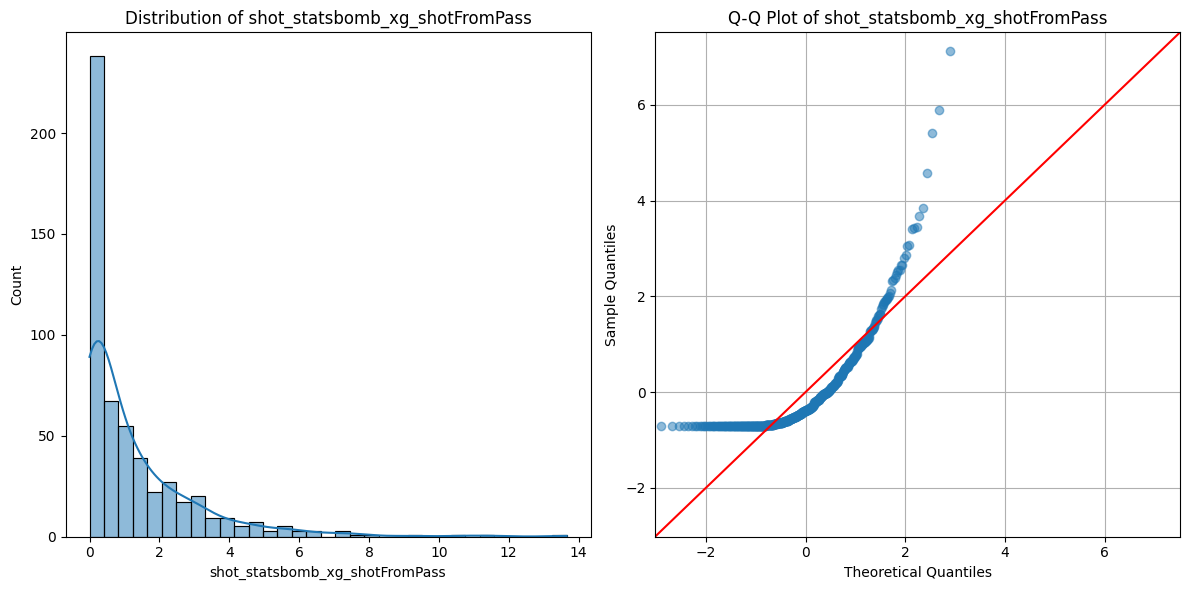

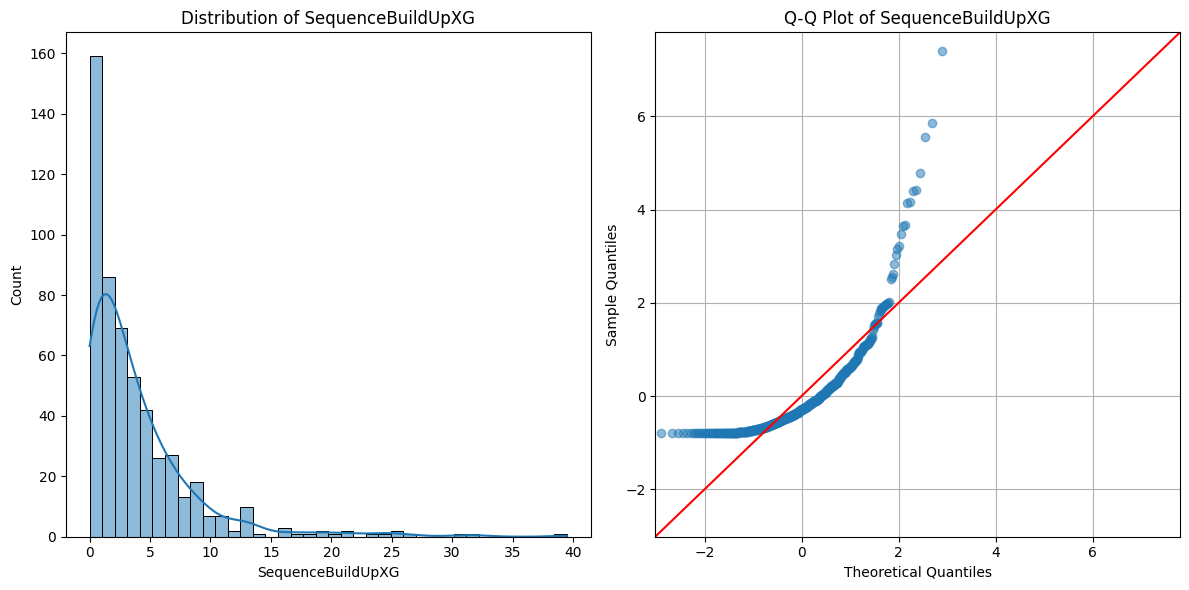

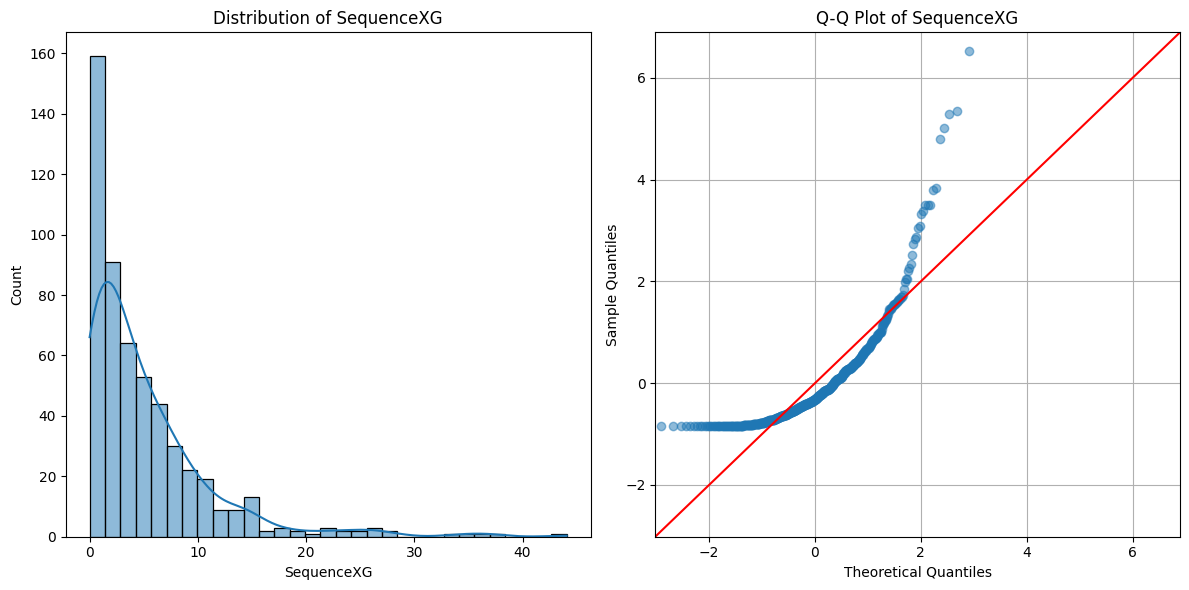

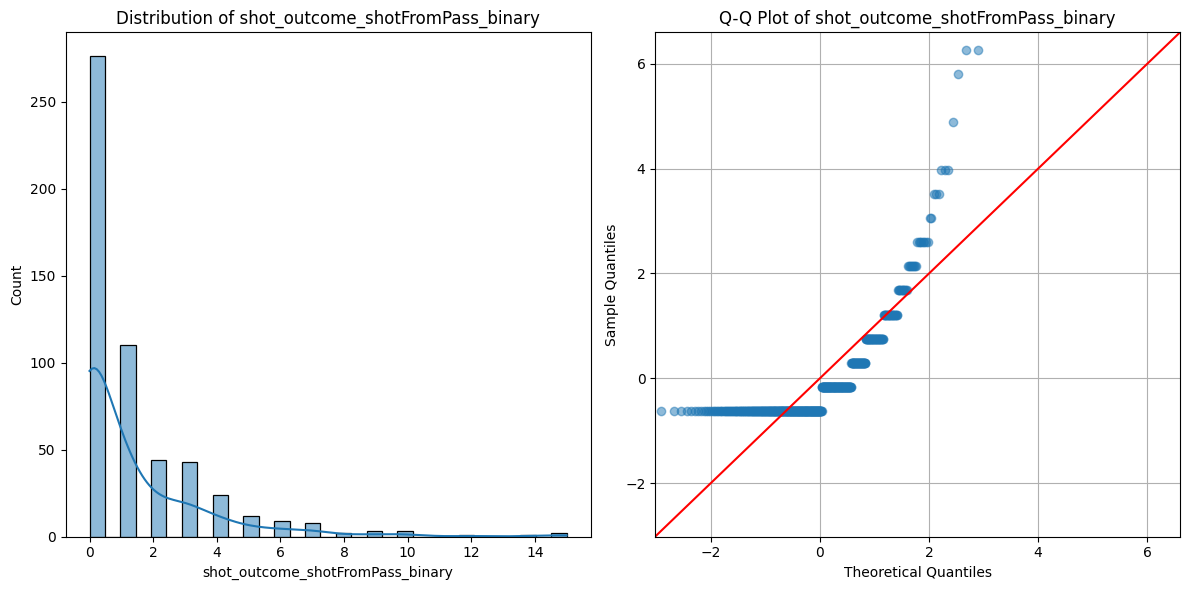

In [255]:

import statsmodels.api as sm

numerical_cols = by_player.select_dtypes(include=['int64', 'float64']).columns
# Loop through numerical columns
for col in numerical_cols:
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot 1: Distribution Plot
    sns.histplot(by_player[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)

    # Plot 2: Q-Q Plot with Confidence Intervals
    sm.qqplot(by_player[col], line='45', alpha=0.5, fit=True, ax=axes[1])
    axes[1].set_title(f"Q-Q Plot of {col}")
    axes[1].grid(True)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

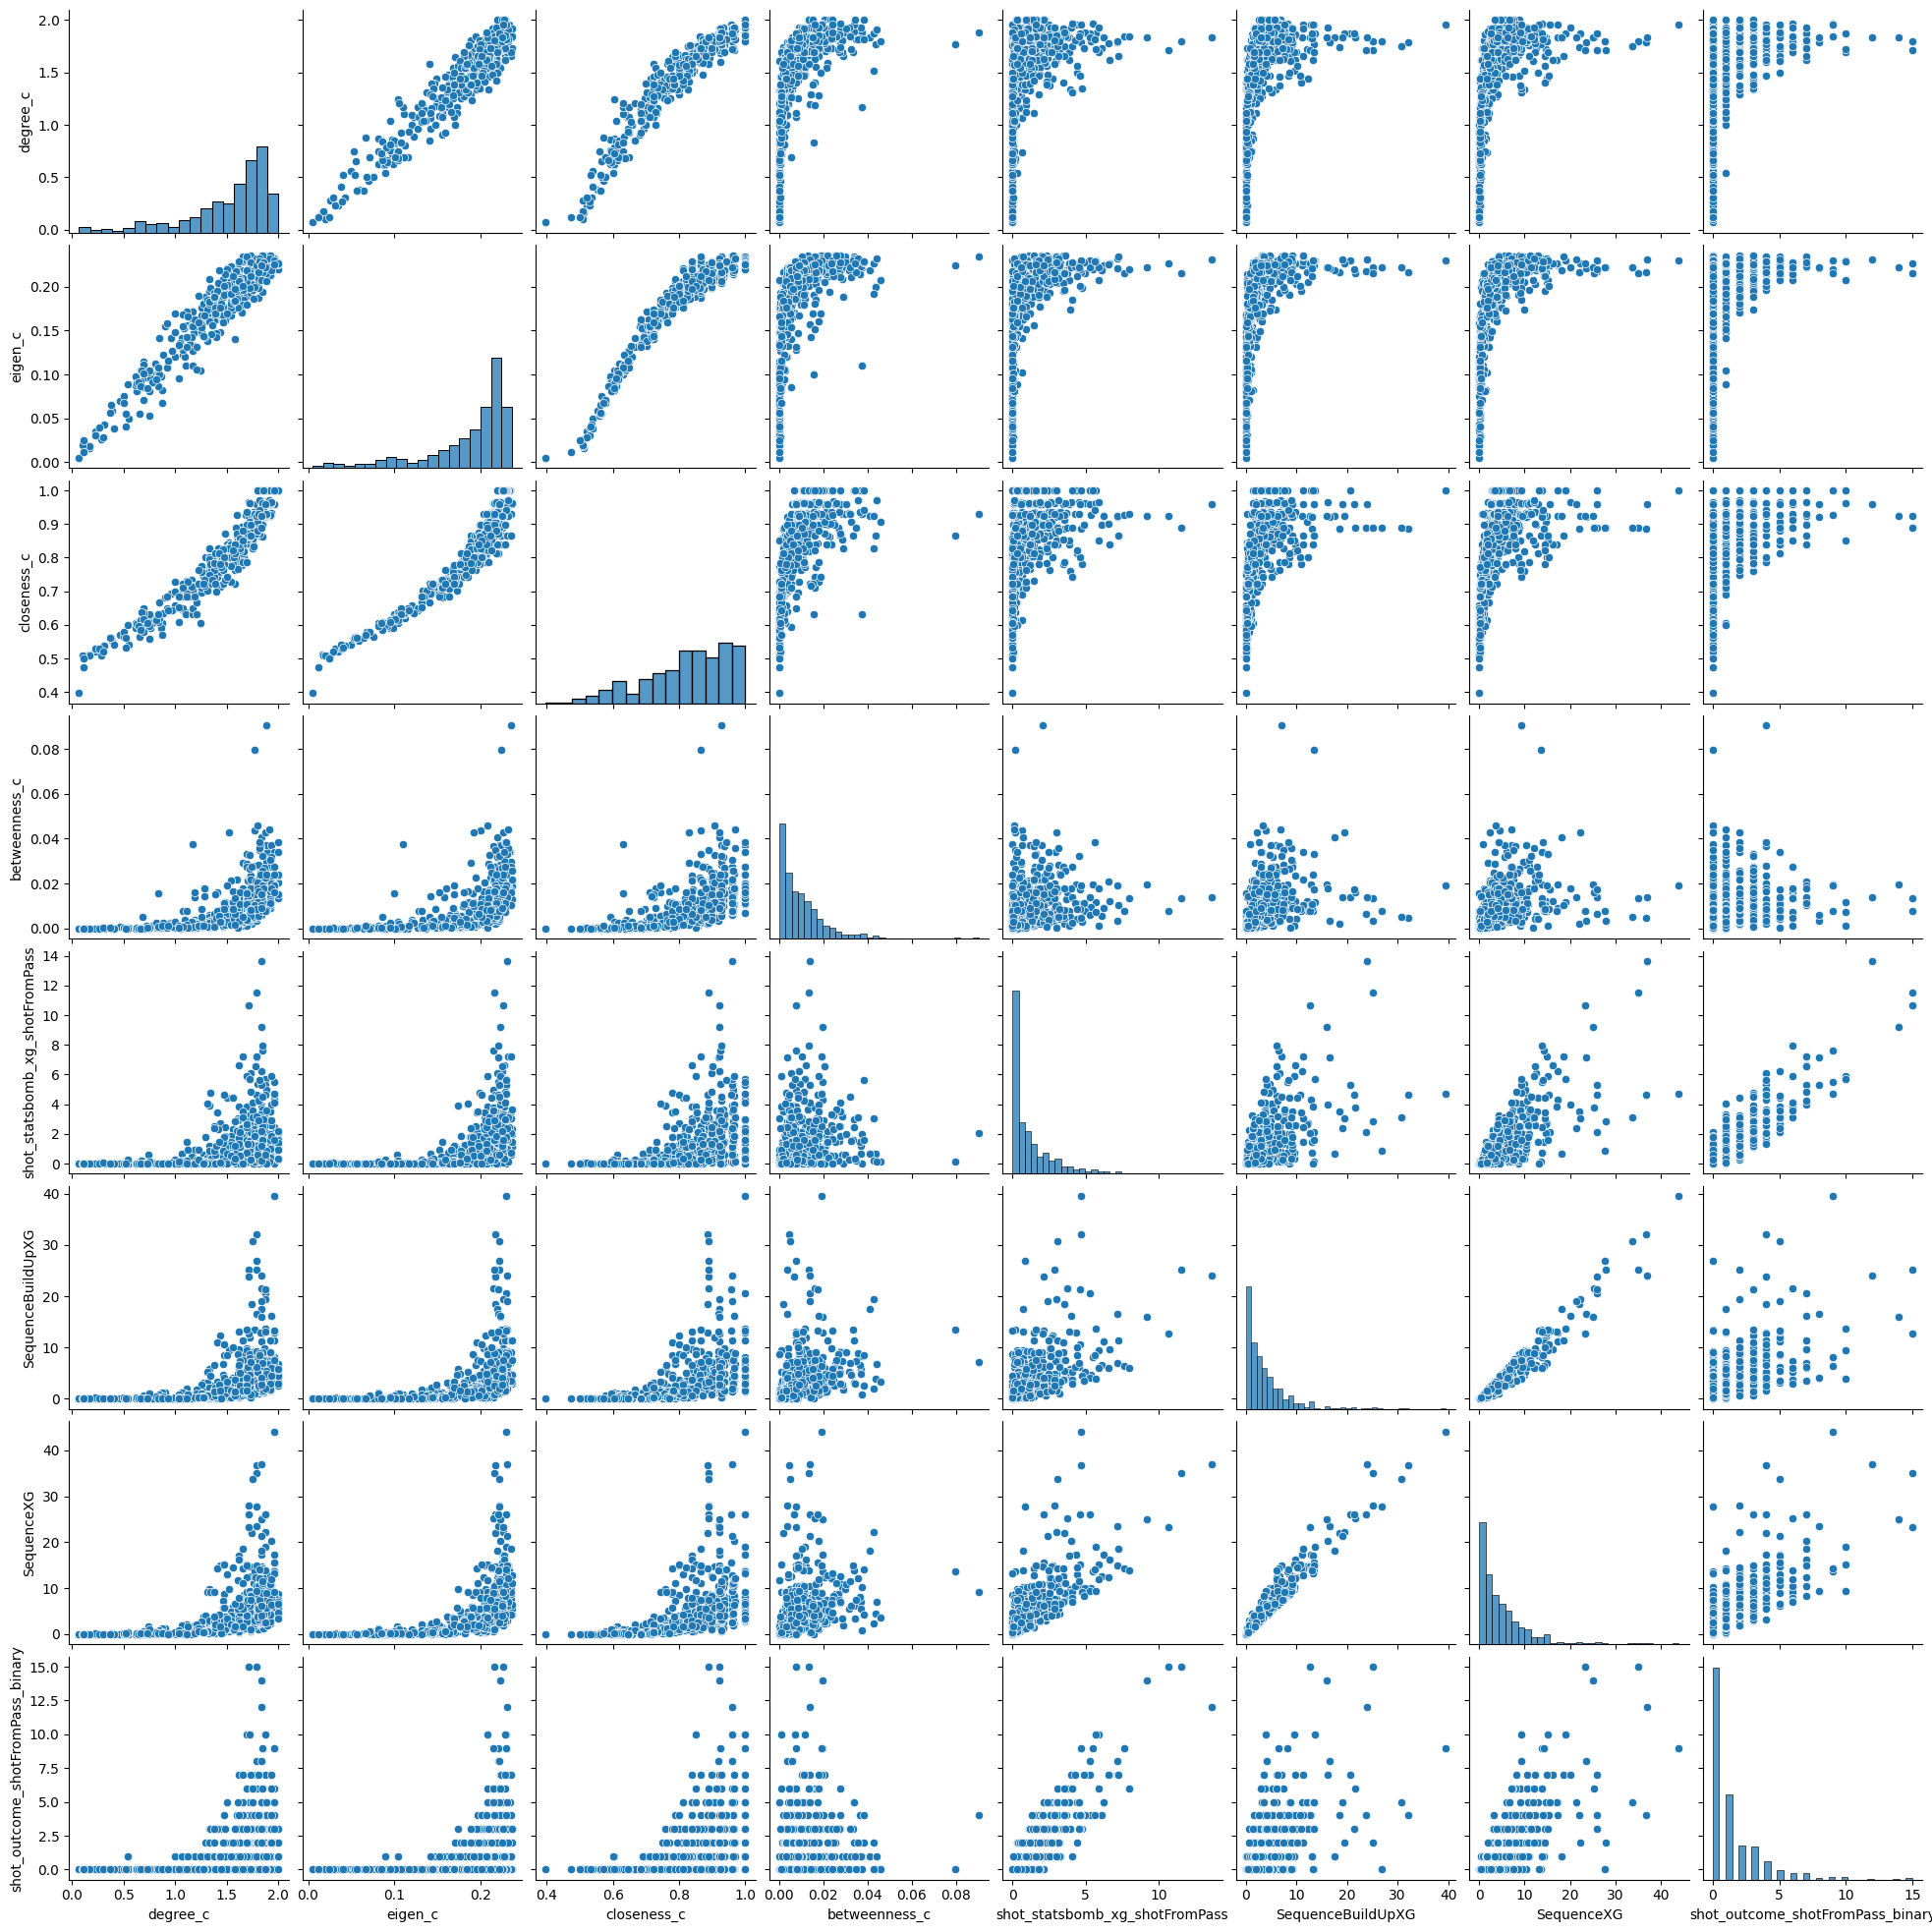

In [256]:
# Pairplot for numerical columns
sns.pairplot(by_player[numerical_cols])
plt.show()


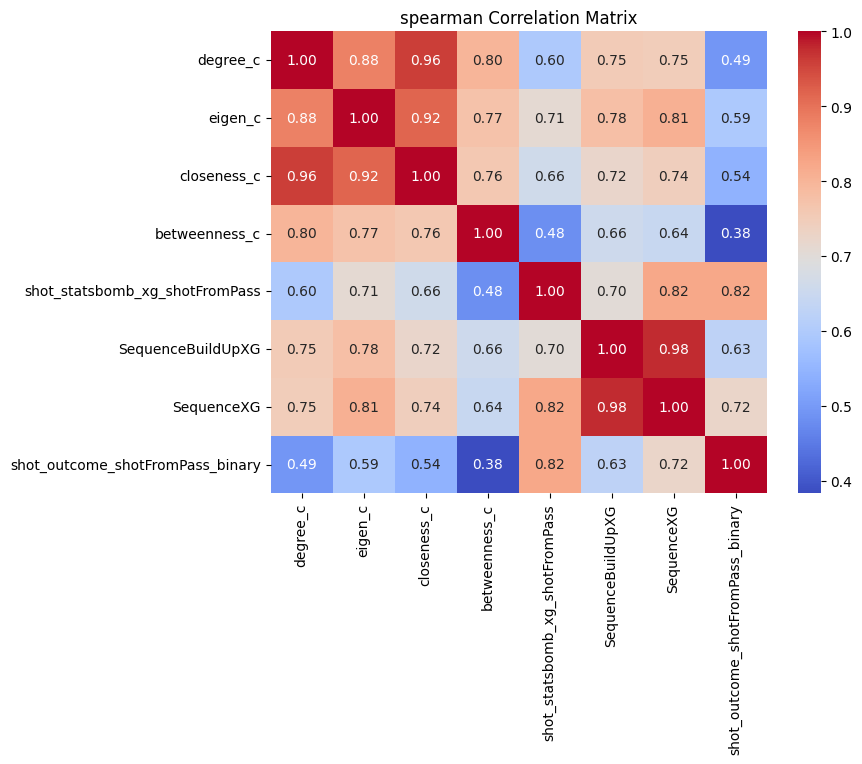

In [257]:
plt.figure(figsize=(8, 6))
sns.heatmap(by_player[numerical_cols].corr(method="spearman"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("spearman Correlation Matrix")
plt.show()

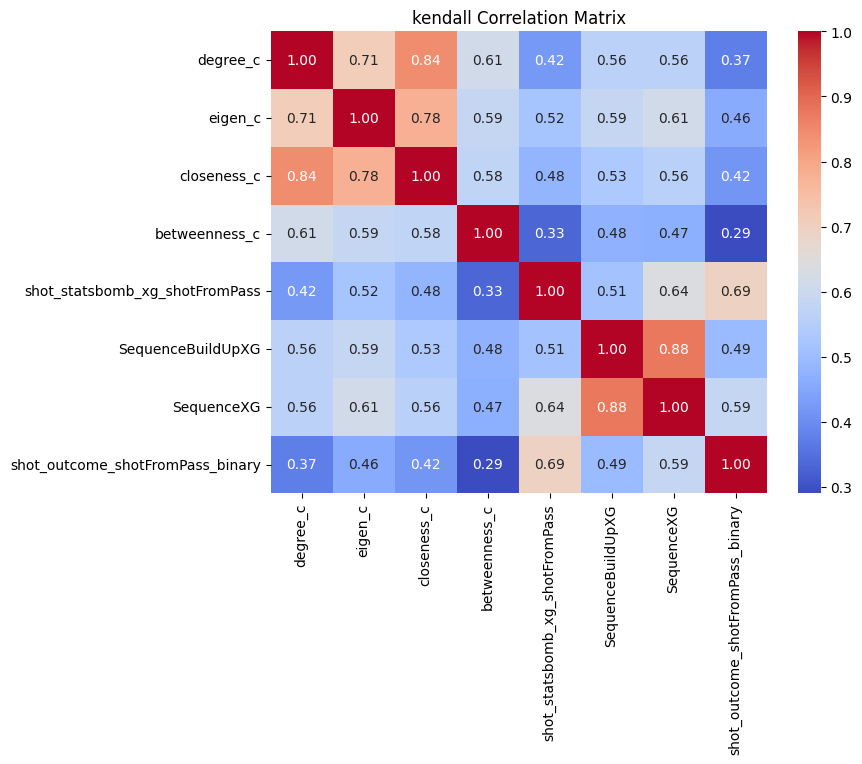

In [258]:
plt.figure(figsize=(8, 6))
sns.heatmap(by_player[numerical_cols].corr(method="kendall"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("kendall Correlation Matrix")
plt.show()

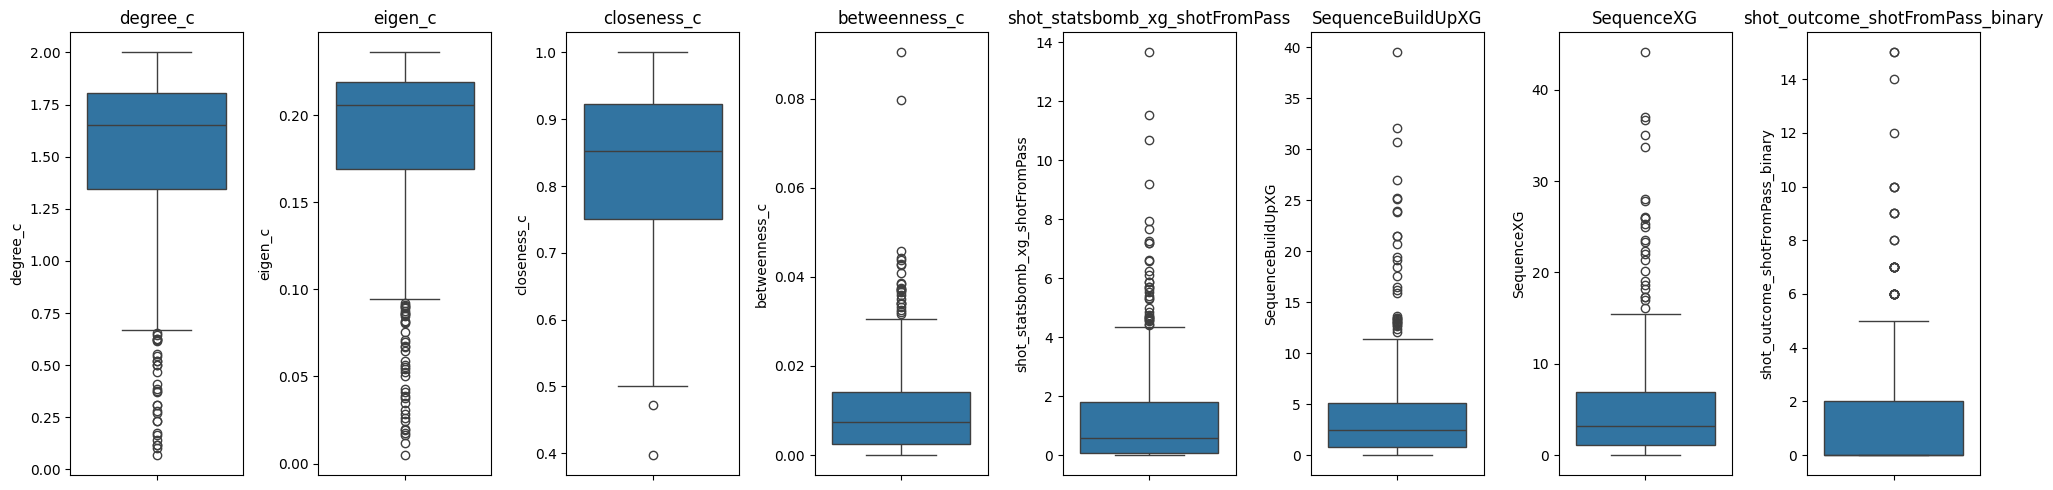

In [259]:
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 5), sharey=False)  # Set sharey=False for independent y-axes

# Create a boxplot for each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=by_player[col], ax=axes[i])
    axes[i].set_title(col)  # Set title for each plot

# Adjust layout
plt.tight_layout()
plt.show()

In [260]:

import pandas as pd

# Define the columns to check for outliers

# Function to remove outliers based on IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter out rows with outliers in the column
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove rows with outliers
cleaned_df = remove_outliers(by_player, numerical_cols)

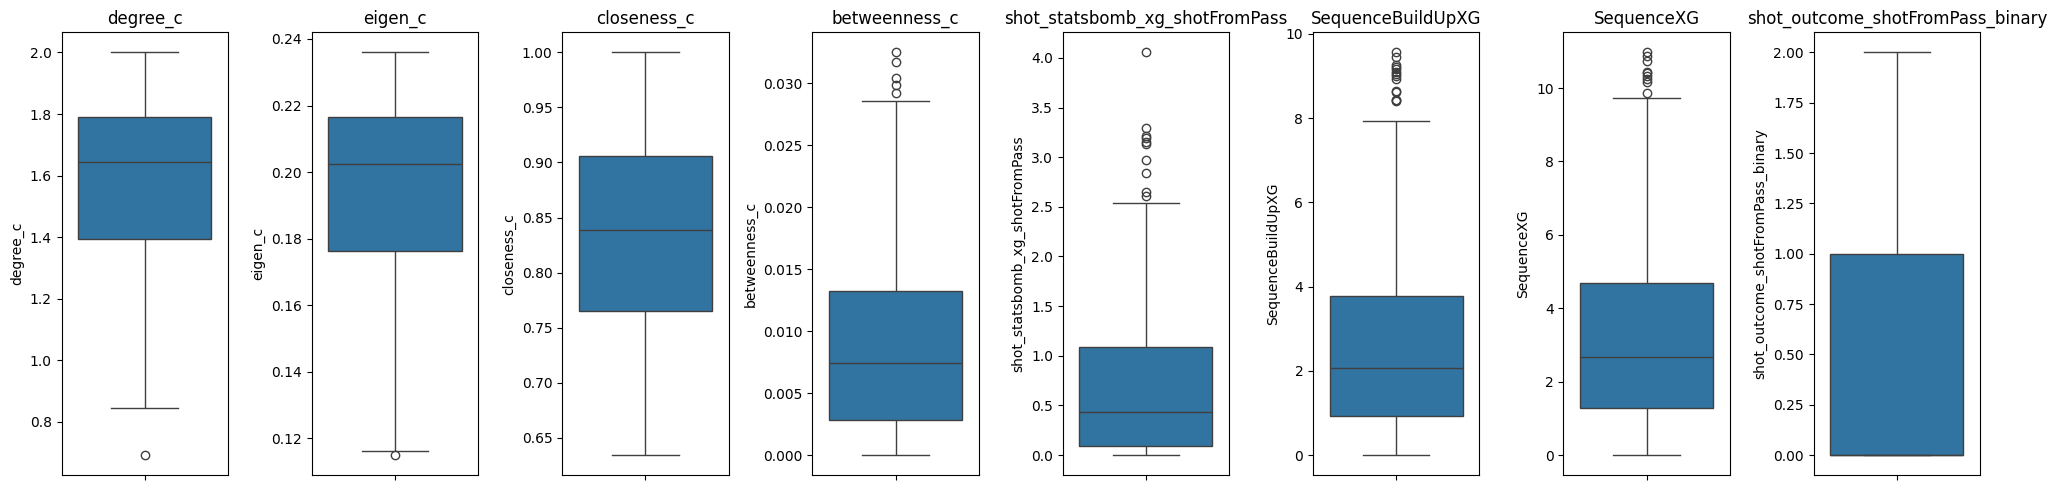

In [261]:

# Set up the figure and axes
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(20, 5), sharey=False)  # Set sharey=False for independent y-axes

# Create a boxplot for each column
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=cleaned_df[col], ax=axes[i])
    axes[i].set_title(col)  # Set title for each plot

# Adjust layout
plt.tight_layout()
plt.show()

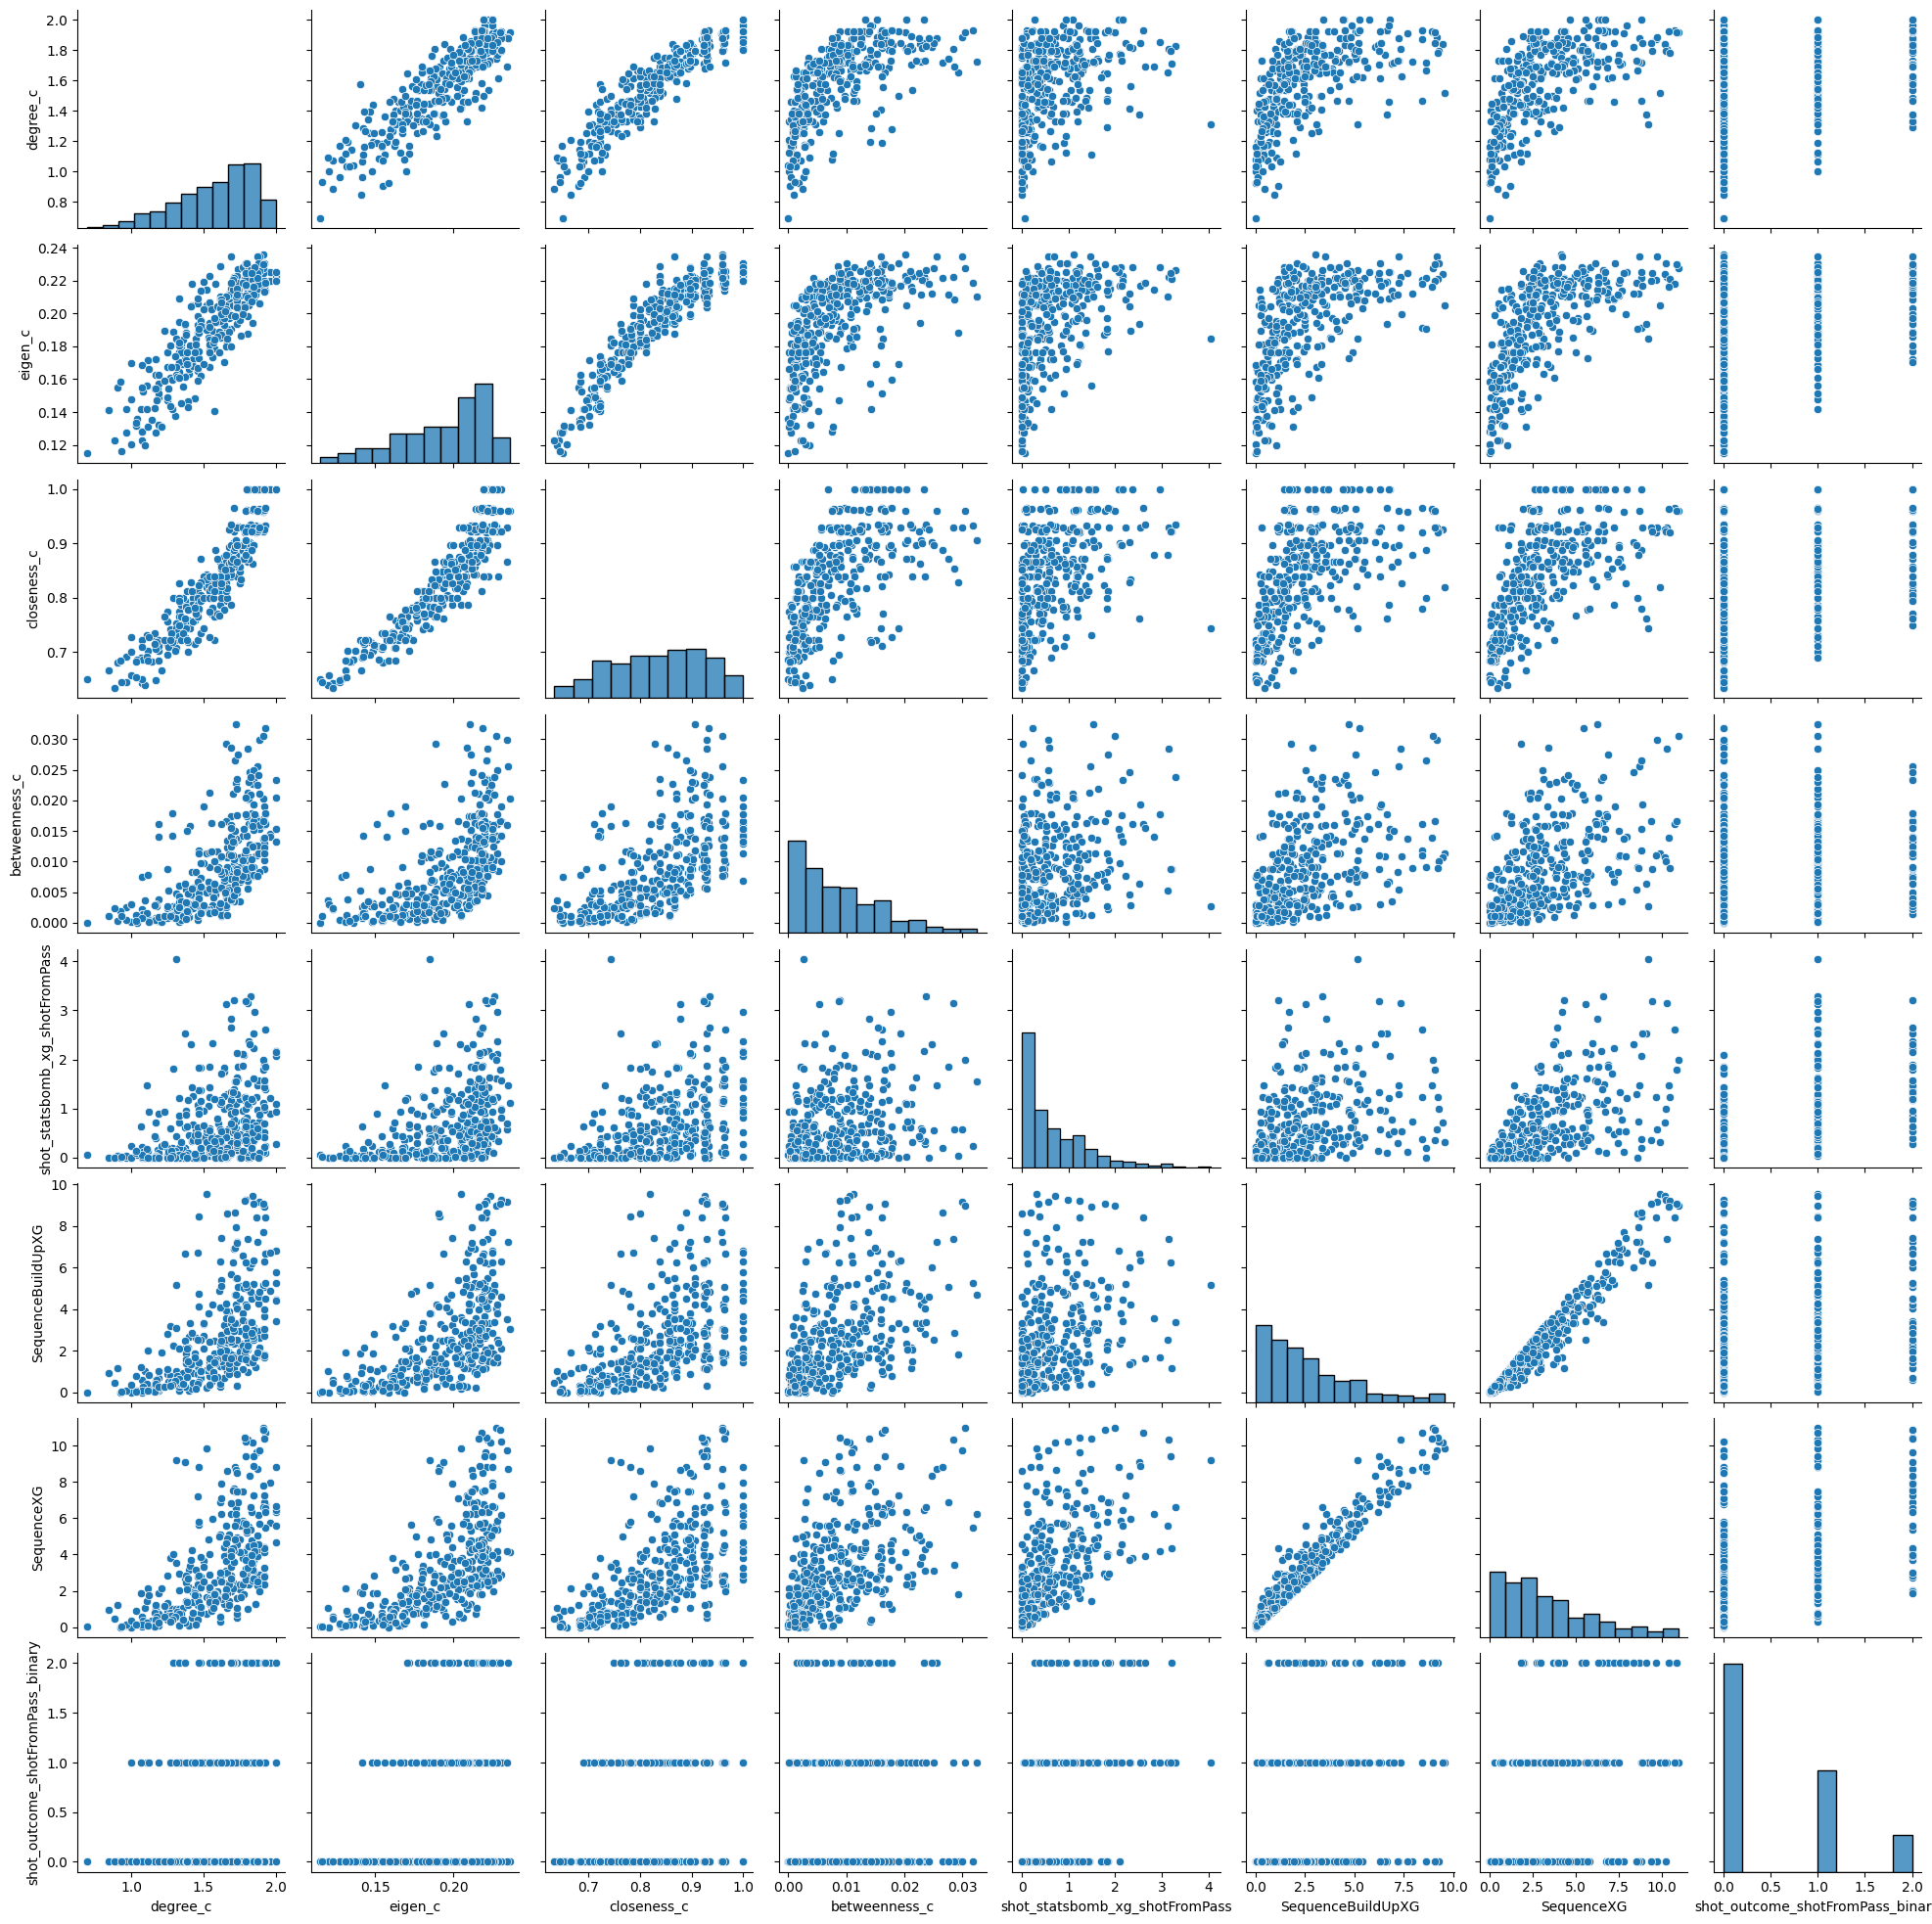

In [262]:
sns.pairplot(cleaned_df[numerical_cols])


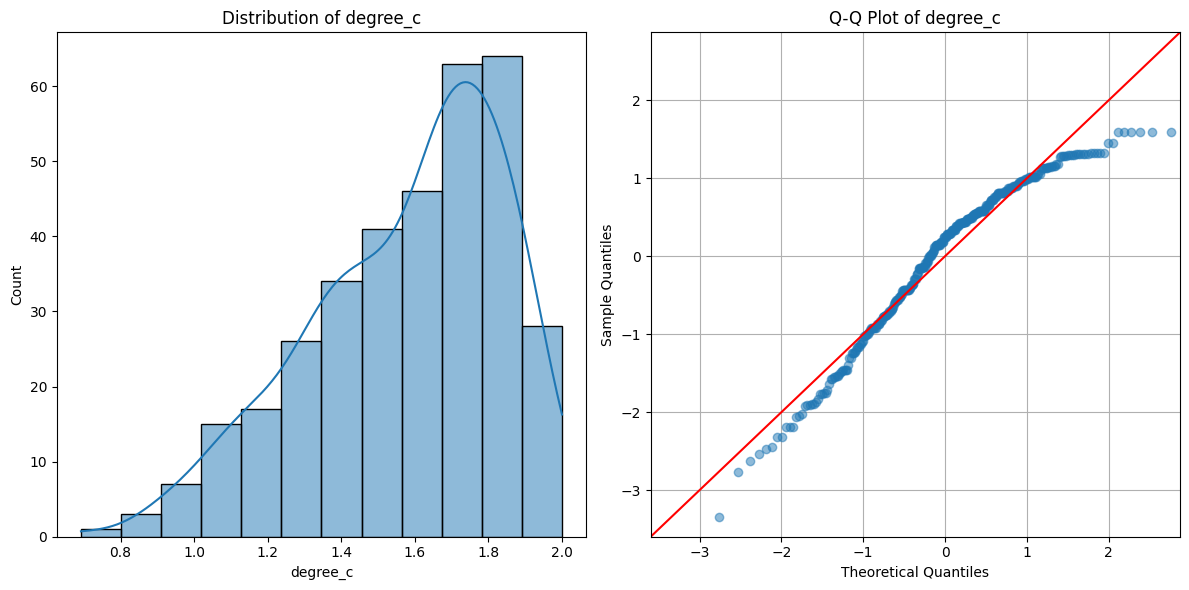

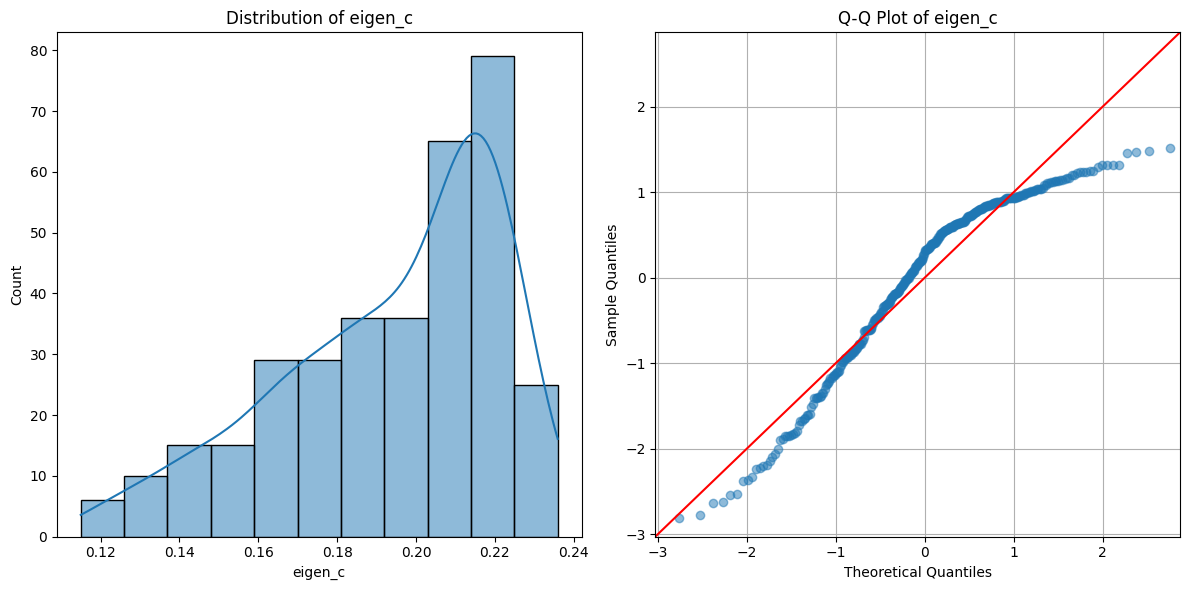

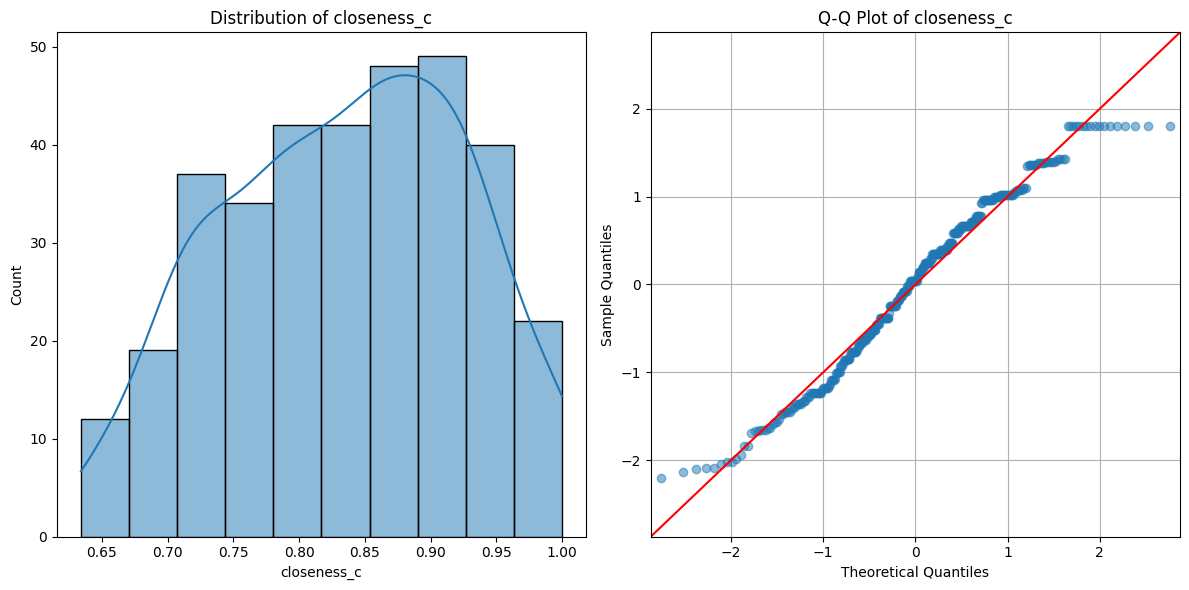

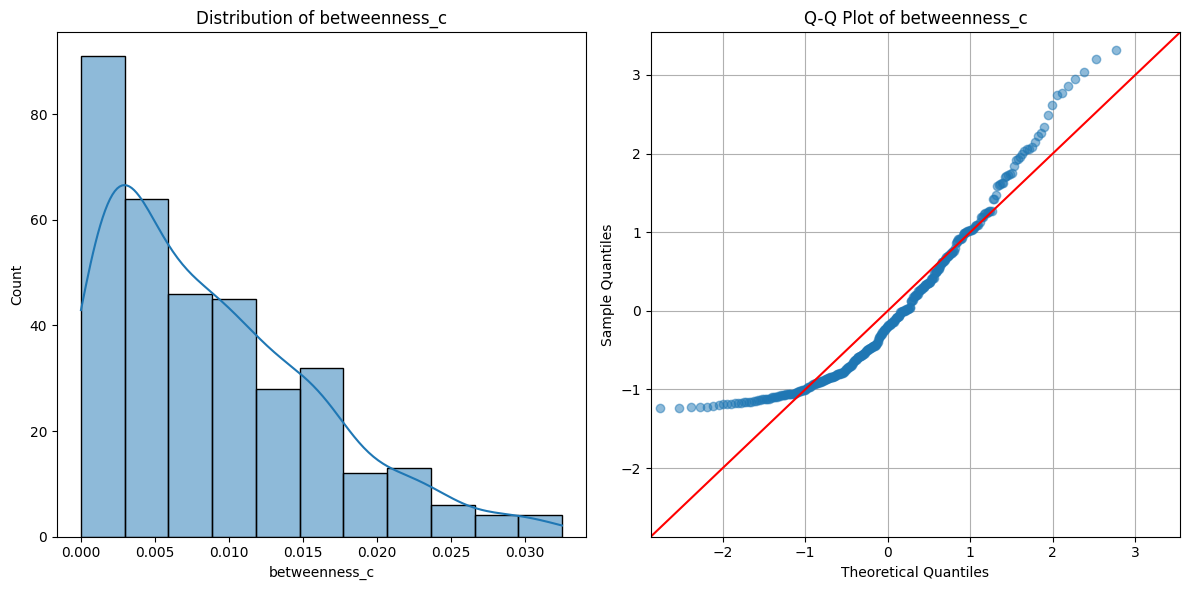

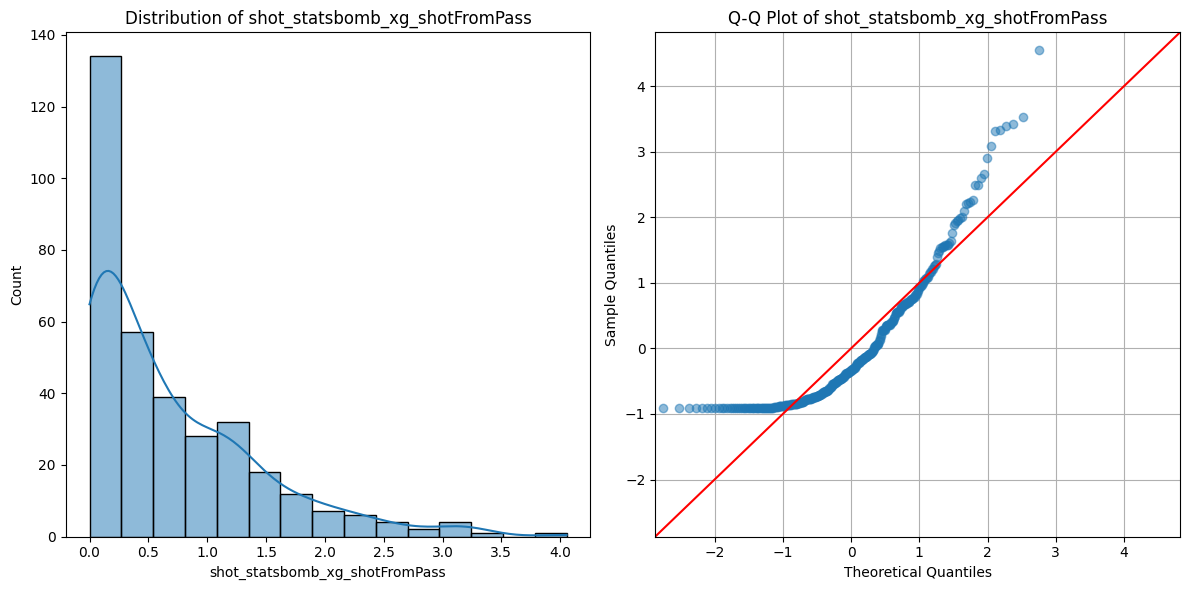

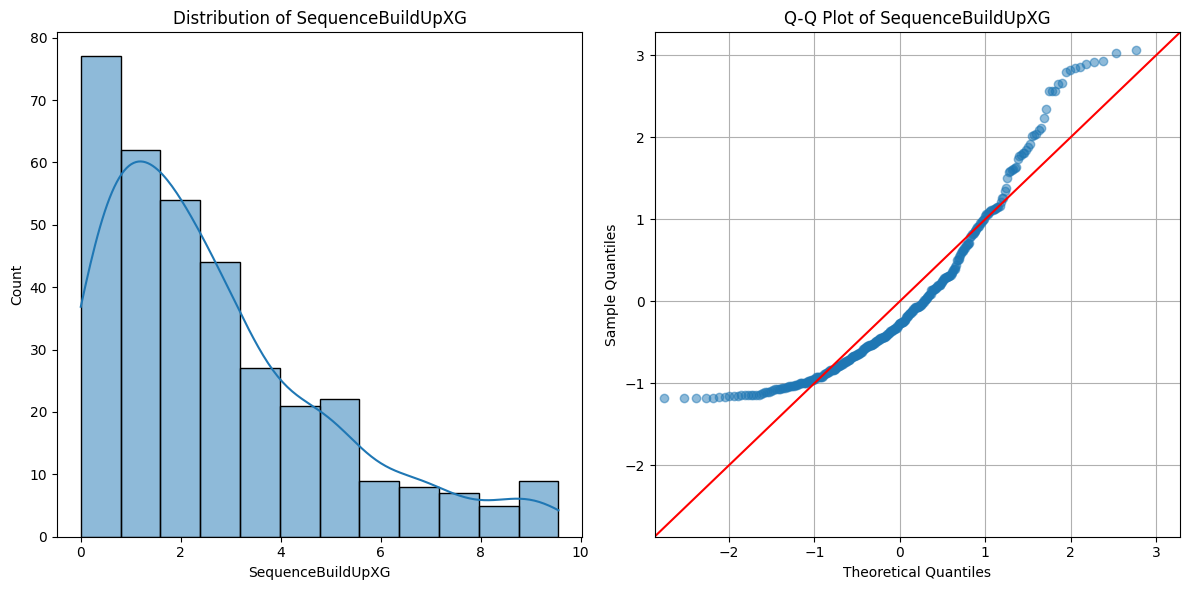

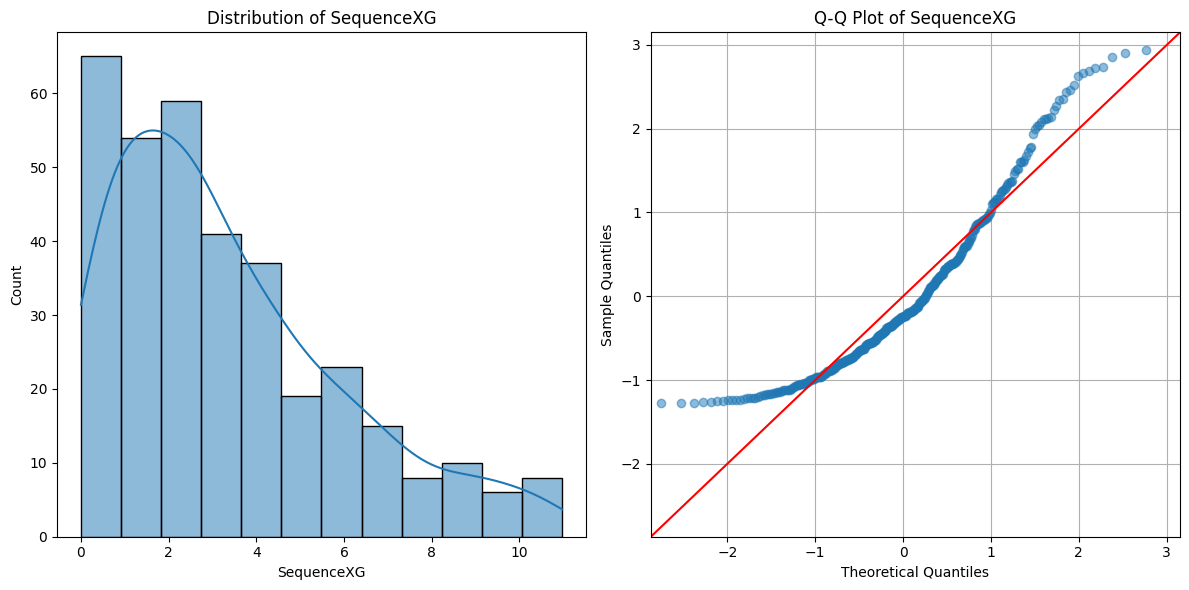

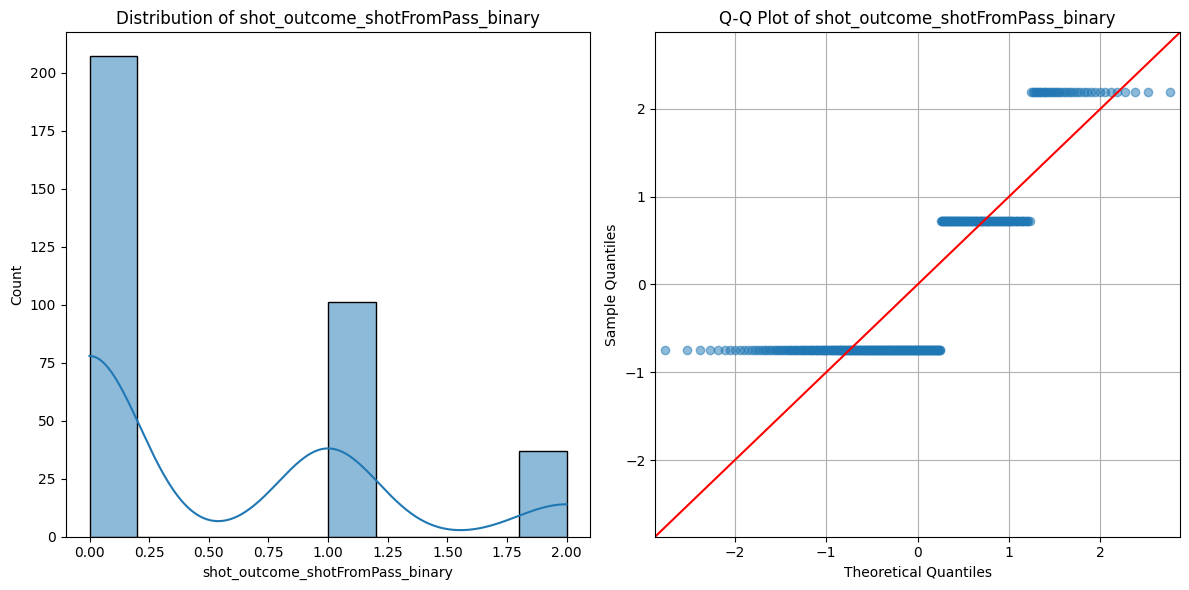

In [263]:

import statsmodels.api as sm

# Loop through numerical columns
for col in numerical_cols:
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot 1: Distribution Plot
    sns.histplot(cleaned_df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)

    # Plot 2: Q-Q Plot with Confidence Intervals
    sm.qqplot(cleaned_df[col], line='45', alpha=0.5, fit=True, ax=axes[1])
    axes[1].set_title(f"Q-Q Plot of {col}")
    axes[1].grid(True)

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()

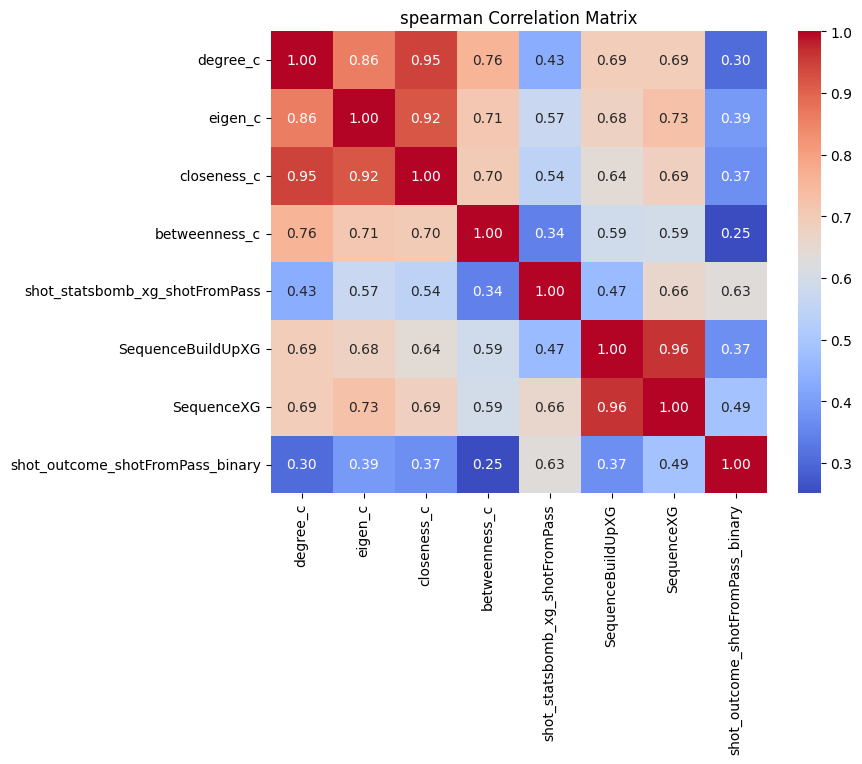

In [264]:
plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_df[numerical_cols].corr(method="spearman"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("spearman Correlation Matrix")
plt.show()

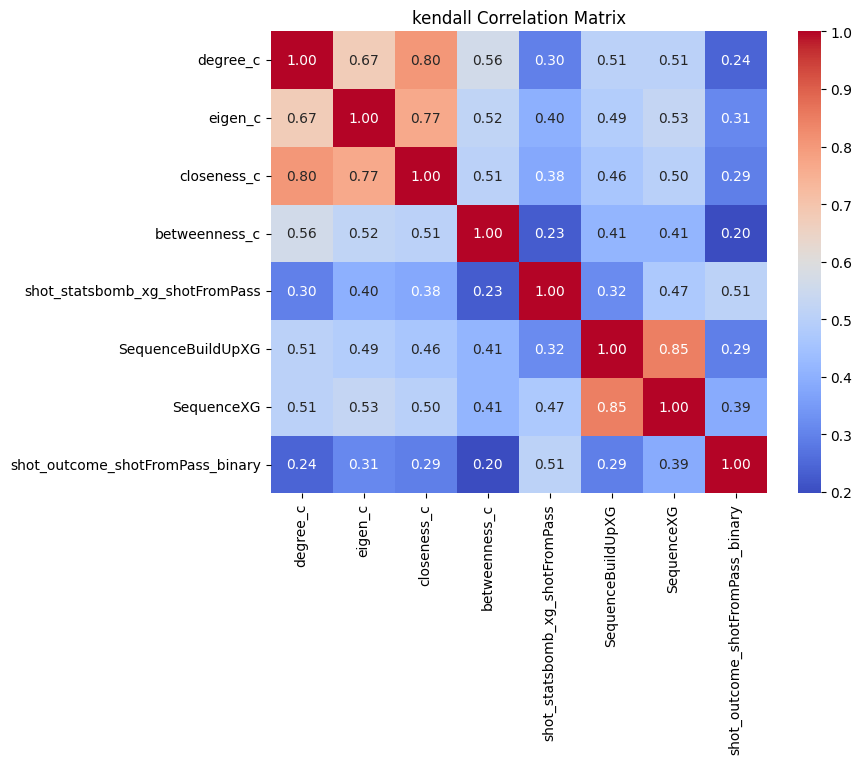

In [265]:
plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_df[numerical_cols].corr(method="kendall"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("kendall Correlation Matrix")
plt.show()

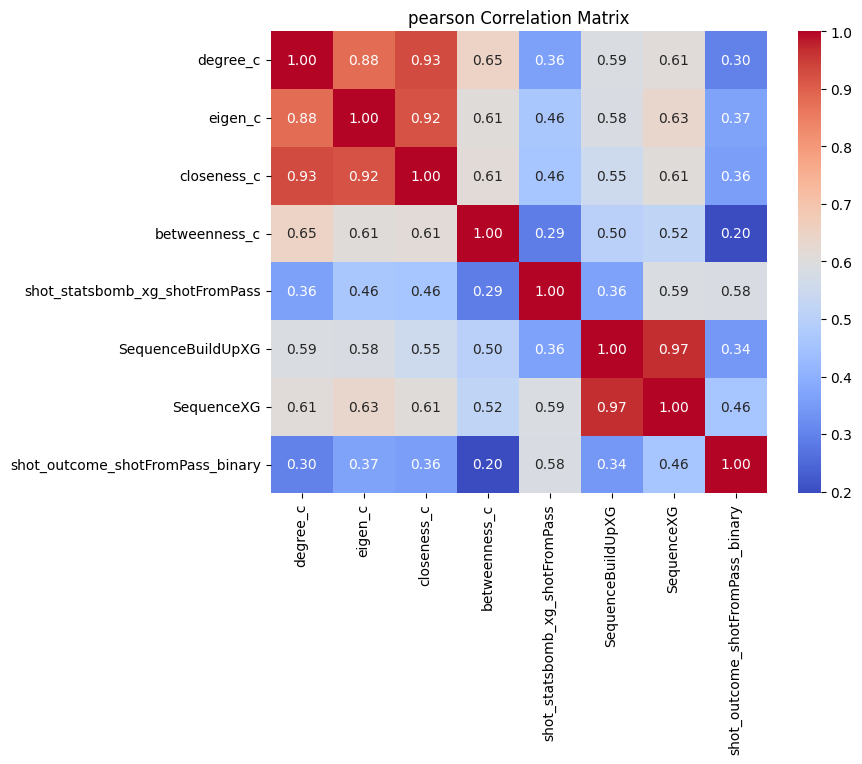

In [266]:
plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_df[numerical_cols].corr(method="pearson"), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("pearson Correlation Matrix")
plt.show()

Fitted Parameters: a = 0.05 ± 0.02, b = 1.65 ± 0.28


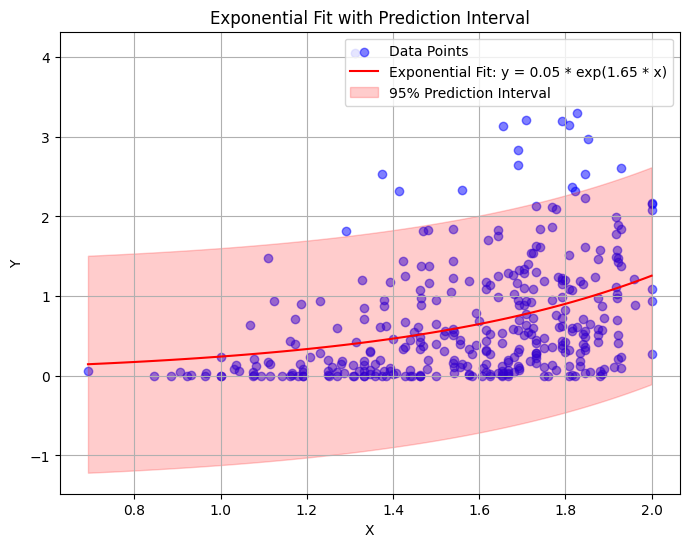

In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential model to the data
x_data = cleaned_df['degree_c']
y_data = cleaned_df['shot_statsbomb_xg_shotFromPass']
popt, pcov = curve_fit(exponential_func, x_data, y_data)  # popt contains [a, b]

# Extract the coefficients and their uncertainties
a_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard deviation of the parameters
a_err, b_err = perr

print(f"Fitted Parameters: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")
# Generate fitted values
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
y_fit = exponential_func(x_fit, a_fit, b_fit)

#  Calculate prediction intervals
n = len(y_data)  # Number of data points
p = len(popt)    # Number of parameters
alpha = 0.05     # 95% confidence level
dof = max(0, n - p)  # Degrees of freedom
t_val = 1.96     # For 95% confidence level (approximation)

# Residuals
residuals = y_data - exponential_func(x_data, *popt)
std_err = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval bounds
ci_upper = y_fit + t_val * std_err
ci_lower = y_fit - t_val * std_err

# Plot the data, fit, and confidence bands
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data Points', color='blue', alpha=0.5)
plt.plot(x_fit, y_fit, label=f'Exponential Fit: y = {a_fit:.2f} * exp({b_fit:.2f} * x)', color='red')
plt.fill_between(x_fit, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Prediction Interval')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exponential Fit with Prediction Interval')
plt.legend()
plt.grid(True)
plt.show()

Fitted Parameters: a = 0.07 ± 0.03, b = 2.18 ± 0.20


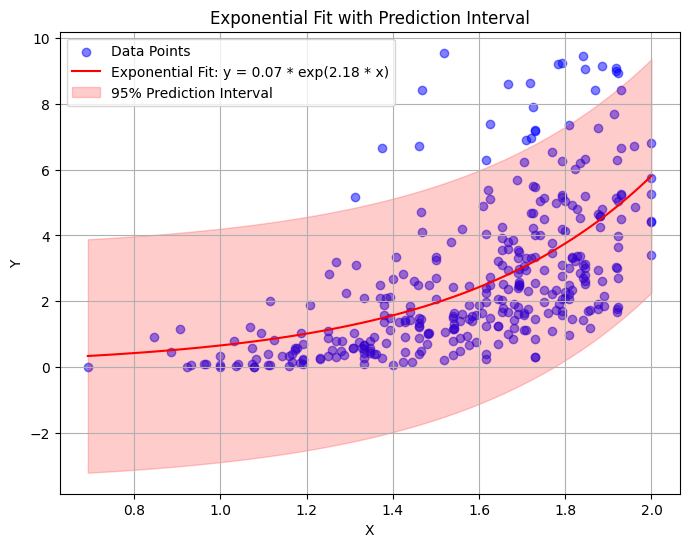

In [462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential model to the data
x_data = cleaned_df['degree_c']
y_data = cleaned_df['SequenceBuildUpXG']
popt, pcov = curve_fit(exponential_func, x_data, y_data)  # popt contains [a, b]

# Extract the coefficients and their uncertainties
a_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard deviation of the parameters
a_err, b_err = perr

print(f"Fitted Parameters: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")
# Generate fitted values
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
y_fit = exponential_func(x_fit, a_fit, b_fit)

#  Calculate prediction intervals
n = len(y_data)  # Number of data points
p = len(popt)    # Number of parameters
alpha = 0.05     # 95% confidence level
dof = max(0, n - p)  # Degrees of freedom
t_val = 1.96     # For 95% confidence level (approximation)

# Residuals
residuals = y_data - exponential_func(x_data, *popt)
std_err = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval bounds
ci_upper = y_fit + t_val * std_err
ci_lower = y_fit - t_val * std_err

# Plot the data, fit, and confidence bands
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data Points', color='blue', alpha=0.5)
plt.plot(x_fit, y_fit, label=f'Exponential Fit: y = {a_fit:.2f} * exp({b_fit:.2f} * x)', color='red')
plt.fill_between(x_fit, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Prediction Interval')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exponential Fit with Prediction Interval')
plt.legend()
plt.grid(True)
plt.show()

Fitted Parameters: a = 0.11 ± 0.04, b = 2.08 ± 0.18


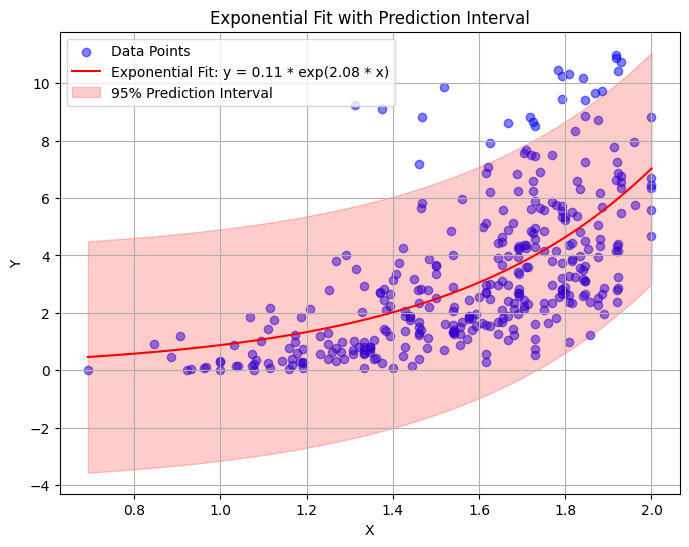

In [463]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential model to the data
x_data = cleaned_df['degree_c']
y_data = cleaned_df['SequenceXG']
popt, pcov = curve_fit(exponential_func, x_data, y_data)  # popt contains [a, b]

# Extract the coefficients and their uncertainties
a_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard deviation of the parameters
a_err, b_err = perr

print(f"Fitted Parameters: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")
# Generate fitted values
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
y_fit = exponential_func(x_fit, a_fit, b_fit)

#  Calculate prediction intervals
n = len(y_data)  # Number of data points
p = len(popt)    # Number of parameters
alpha = 0.05     # 95% confidence level
dof = max(0, n - p)  # Degrees of freedom
t_val = 1.96     # For 95% confidence level (approximation)

# Residuals
residuals = y_data - exponential_func(x_data, *popt)
std_err = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval bounds
ci_upper = y_fit + t_val * std_err
ci_lower = y_fit - t_val * std_err

# Plot the data, fit, and confidence bands
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data Points', color='blue', alpha=0.5)
plt.plot(x_fit, y_fit, label=f'Exponential Fit: y = {a_fit:.2f} * exp({b_fit:.2f} * x)', color='red')
plt.fill_between(x_fit, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Prediction Interval')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exponential Fit with Prediction Interval')
plt.legend()
plt.grid(True)
plt.show()

Fitted Parameters: a = 0.03 ± 0.01, b = 22.90 ± 1.92


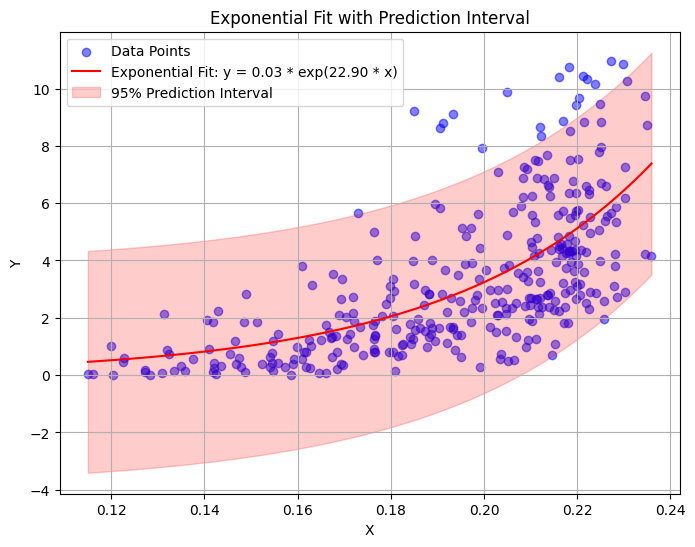

In [464]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential model to the data
x_data = cleaned_df['eigen_c']
y_data = cleaned_df['SequenceXG']
popt, pcov = curve_fit(exponential_func, x_data, y_data)  # popt contains [a, b]

# Extract the coefficients and their uncertainties
a_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))  # Standard deviation of the parameters
a_err, b_err = perr

print(f"Fitted Parameters: a = {a_fit:.2f} ± {a_err:.2f}, b = {b_fit:.2f} ± {b_err:.2f}")
# Generate fitted values
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
y_fit = exponential_func(x_fit, a_fit, b_fit)

#  Calculate prediction intervals
n = len(y_data)  # Number of data points
p = len(popt)    # Number of parameters
alpha = 0.05     # 95% confidence level
dof = max(0, n - p)  # Degrees of freedom
t_val = 1.96     # For 95% confidence level (approximation)

# Residuals
residuals = y_data - exponential_func(x_data, *popt)
std_err = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval bounds
ci_upper = y_fit + t_val * std_err
ci_lower = y_fit - t_val * std_err

# Plot the data, fit, and confidence bands
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data Points', color='blue', alpha=0.5)
plt.plot(x_fit, y_fit, label=f'Exponential Fit: y = {a_fit:.2f} * exp({b_fit:.2f} * x)', color='red')
plt.fill_between(x_fit, ci_lower, ci_upper, color='red', alpha=0.2, label='95% Prediction Interval')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exponential Fit with Prediction Interval')
plt.legend()
plt.grid(True)
plt.show()

In [267]:
#by_player.to_excel('players_pass_data.xlsx', index=False, sheet_name='Stats')

 ### **Görselleştirme**

In [268]:

team_name = "Barcelona"  # Replace with the desired team name

team_graphs[team_name].nodes(data=True)

NodeDataView({'Neymar da Silva Santos Junior': {}, 'Luis Alberto Suárez Díaz': {}, 'Sergio Busquets i Burgos': {}, 'Andrés Iniesta Luján': {}, 'Jérémy Mathieu': {}, 'Gerard Piqué Bernabéu': {}, 'Jordi Alba Ramos': {}, 'Daniel Alves da Silva': {}, 'Sergi Roberto Carnicer': {}, 'Munir El Haddadi Mohamed': {}, 'Claudio Andrés Bravo Muñoz': {}, 'Marc Bartra Aregall': {}, 'Sandro Ramírez Castillo': {}, 'Javier Alejandro Mascherano': {}, 'Ivan Rakitić': {}, 'Douglas Pereira dos Santos': {}, 'Gerard Gumbau Garriga': {}, 'Aleix Vidal Parreu': {}, 'Arda Turan': {}, 'Lionel Andrés Messi Cuccittini': {}, 'Sergi Samper Montaña': {}, 'Thomas Vermaelen': {}, 'Marc-André ter Stegen': {}, 'Adriano Correia Claro': {}, 'Rafael Alcântara do Nascimento': {}})

In [273]:
def assign_properties(g):
    # Centrality calculation
    node_centralities = nx.degree_centrality(g)

    # Graph properties
    g.graph['node_border_size'] = 1.5
    g.graph['node_border_color'] = 'white'
    g.graph['edge_opacity'] = 0.9

    # Node properties: Size by centrality, shape by size, color by community
    for node_id in g.nodes:
        node = g.nodes[node_id]
        node['size'] = 10 + node_centralities[node_id] * 100
        print(node)

    # Edge properties: Size by centrality, color by community (within=community color, between=black)
    for edge_id in g.edges(data=True):
        edge = g.nodes[edge_id]
        source, target, attrs = edge
        weight = attrs.get('weight', None)
        edge['size'] = weight * 0.5


In [274]:
g = team_graphs[team_name].copy()

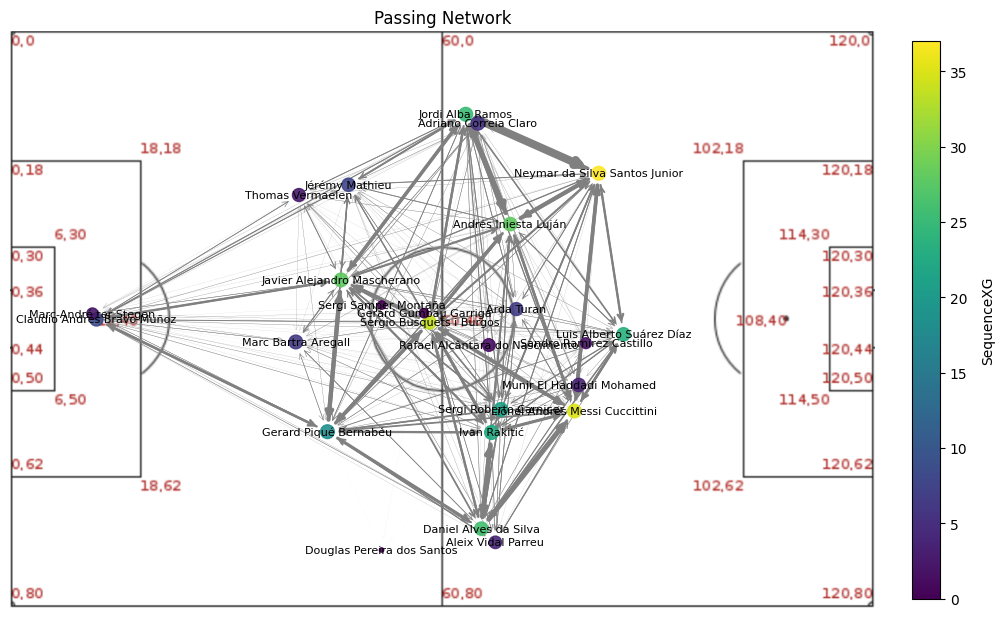

In [309]:
network_viz(season_network_DF,season_network)

In [300]:

def network_viz_filtered(df, G, centrality_threshold=0.1, edge_weight_threshold=5):
    # Compute player positions
    pass_positions = df[['player', 'x', 'y']].rename(columns={'x': 'pos_x', 'y': 'pos_y'})
    receive_positions = df[['pass_recipient', 'pass_end_x', 'pass_end_y']].rename(
        columns={'pass_recipient': 'player', 'pass_end_x': 'pos_x', 'pass_end_y': 'pos_y'}
    )

    # Combine pass and receive positions
    all_positions = pd.concat([pass_positions, receive_positions], ignore_index=True)

    # Calculate average positions
    average_positions_df = all_positions.groupby('player')[['pos_x', 'pos_y']].mean()

    # Filter edges by weight
    edges_to_keep = [
        (source, target) for source, target, data in G.edges(data=True) if data.get('weight', 0) >= edge_weight_threshold
    ]

    # Create a subgraph with filtered edges
    G_filtered = G.edge_subgraph(edges_to_keep).copy()

    # Filter nodes by centrality
    centrality = nx.degree_centrality(G_filtered)
    nodes_to_keep = [node for node, value in centrality.items() if value >= centrality_threshold]
    G_filtered = G_filtered.subgraph(nodes_to_keep).copy()

    # Remove isolated nodes if needed
    G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

    # Update average positions for filtered nodes
    average_positions = {
        node: (average_positions_df.loc[node]['pos_x'], average_positions_df.loc[node]['pos_y'])
        for node in G_filtered.nodes if node in average_positions_df.index
    }

    # Node size and color calculations
    min_size, max_size = 10, 200  # Desired size range
    min_centrality = min(centrality.values(), default=0)
    max_centrality = max(centrality.values(), default=1)

    node_sizes = [
        min_size + ((centrality[node] - min_centrality) / (max_centrality - min_centrality)) * (max_size - min_size)
        for node in G_filtered.nodes
    ]

    grouped = df.groupby('player')['SequenceXG'].sum().reset_index()
    grouped.set_index('player', inplace=True)
    norm = mcolors.Normalize(vmin=grouped['SequenceXG'].min(), vmax=grouped['SequenceXG'].max())
    colormap = cm.viridis
    node_colors = [
        mcolors.to_hex(colormap(norm(grouped.loc[node]['SequenceXG']))) if node in grouped.index else '#808080'
        for node in G_filtered.nodes
    ]

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 8))

    # Add background field image
    try:
        field_image = plt.imread("pitch.png")  # Path to the football field image
        ax.imshow(field_image, extent=[0, 120, 80, 0], zorder=0)  # Adjust to field dimensions
    except FileNotFoundError:
        print("Field image not found. Please ensure 'pitch.png' is in the correct path.")

    # Draw nodes and edges
    nx.draw_networkx_nodes(G_filtered, average_positions, node_size=node_sizes, node_color=node_colors, ax=ax, alpha=0.9)
    nx.draw_networkx_labels(G_filtered, average_positions, font_size=8, font_color="black", ax=ax)
    nx.draw_networkx_edges(
        G_filtered,
        average_positions,
        edge_color="gray",
        width=[data['weight'] * 0.01 for _, _, data in G_filtered.edges(data=True)],
        arrowstyle='->',
        arrowsize=10,
        ax=ax
    )

    # Add colorbar for node colors
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('SequenceXG', rotation=90, labelpad=10)

    # Axis settings
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_axis_off()  # Hide axes
    ax.invert_yaxis()  # Invert y-axis to match football field orientation

    plt.title("Filtered Passing Network")
    plt.show()

def visualize_thresholds(G):
    # Compute centrality and edge weights
    centrality = nx.degree_centrality(G)
    edge_weights = [data.get('weight', 0) for _, _, data in G.edges(data=True)]

    # Convert centrality and edge weights to DataFrame for visualization
    centrality_df = pd.DataFrame({'Node': list(centrality.keys()), 'Centrality': list(centrality.values())})
    edge_weights_df = pd.DataFrame({'Edge': [f"{u}->{v}" for u, v, _ in G.edges(data=True)], 'Weight': edge_weights})

    # Plot centrality distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(centrality_df['Centrality'], bins=50, color='skyblue', edgecolor='black')
    plt.title("Centrality Distribution")
    plt.xlabel("Centrality Value")
    plt.ylabel("Frequency")

    # Plot edge weight distribution
    plt.subplot(1, 2, 2)
    plt.hist(edge_weights_df['Weight'], bins=50, color='salmon', edgecolor='black')
    plt.title("Edge Weight Distribution")
    plt.xlabel("Edge Weight")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # Print statistics for better threshold decisions
    print("Centrality Stats:")
    print(centrality_df['Centrality'].describe())
    print("\nEdge Weight Stats:")
    print(edge_weights_df['Weight'].describe())



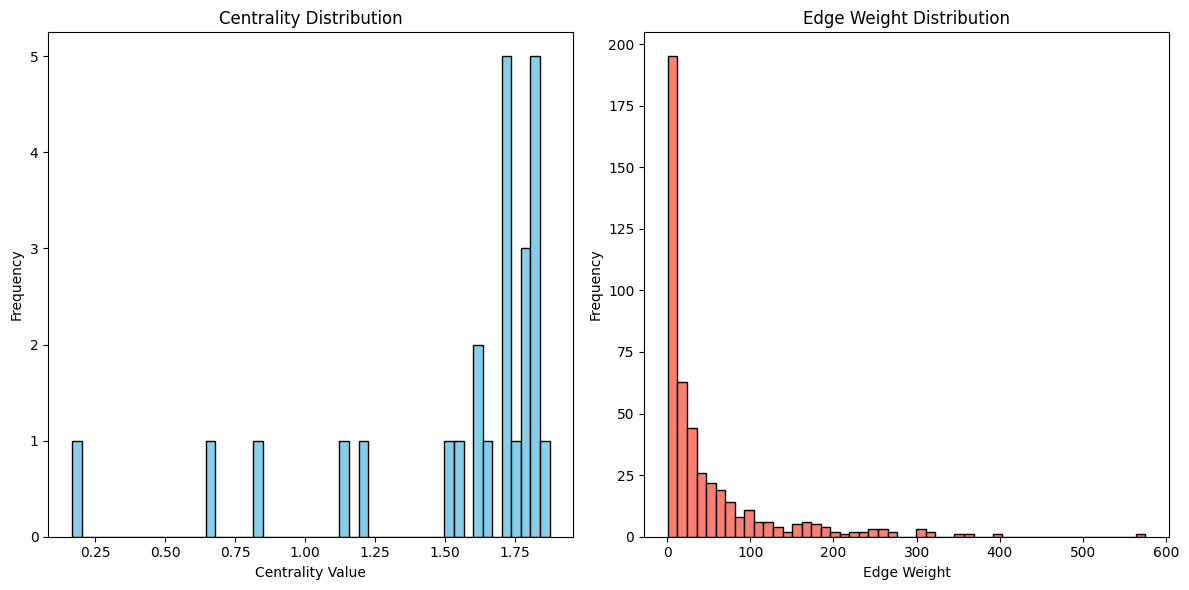

Centrality Stats:
count    25.000000
mean      1.546667
std       0.427180
min       0.166667
25%       1.541667
50%       1.708333
75%       1.791667
max       1.875000
Name: Centrality, dtype: float64

Edge Weight Stats:
count    464.000000
mean      47.698276
std       72.279691
min        1.000000
25%        5.000000
50%       18.000000
75%       58.000000
max      575.000000
Name: Weight, dtype: float64


In [299]:
visualize_thresholds(season_network)

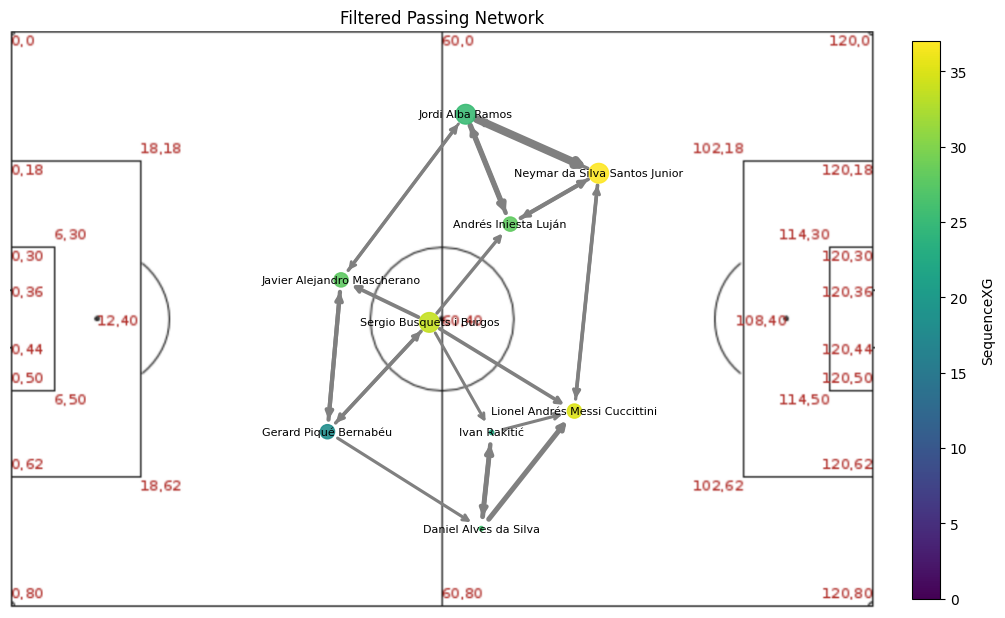

In [304]:
network_viz_filtered(season_network_DF,season_network,edge_weight_threshold=200)

In [502]:
season_network_DF.shape


(276763, 46)

In [507]:
season_network_DF[season_network_DF["player"]=="Francisco Medina Luna"]["team"].unique()

array(['Rayo Vallecano', 'Granada'], dtype=object)

In [ ]:

gv.d3(season_network)


### Takım


In [347]:
by_player_match

player           team  match_id  degree_c   eigen_c  \
0          Abdoul Karim Yoda         Getafe    266498  1.615385  0.210081   
1          Abdoul Karim Yoda         Getafe   3825669  1.615385  0.210081   
2          Abdoul Karim Yoda         Getafe   3825697  1.615385  0.210081   
3          Abdoul Karim Yoda         Getafe   3825712  1.615385  0.210081   
4          Abdoul Karim Yoda         Getafe   3825737  1.615385  0.210081   
...                      ...            ...       ...       ...       ...   
10436  Óscar de Marcos Arana  Athletic Club   3825835  1.958333  0.225568   
10437  Óscar de Marcos Arana  Athletic Club   3825838  1.958333  0.225568   
10438  Óscar de Marcos Arana  Athletic Club   3825866  1.958333  0.225568   
10439  Óscar de Marcos Arana  Athletic Club   3825870  1.958333  0.225568   
10440  Óscar de Marcos Arana  Athletic Club   3825877  1.958333  0.225568   

       closeness_c  betweenness_c  shot_statsbomb_xg_shotFromPass  \
0         0.866667       0.002409                        0.000000   
1         0.866667       0.002409                        0.000000   
2         0.866667       0.002409                        0.000000   
3         0.866667       0.002409                        0.000000   
4         0.866667       0.002409                        0.044651   
...            ...            ...                             ...   
10436     1.000000       0.016095                        0.000000   
10437     1.000000       0.016095                        0.000000   
10438     1.000000       0.016095                        0.007785   
10439     1.000000       0.016095                        0.000000   
10440     1.000000       0.016095                        0.000000   

       SequenceBuildUpXG  SequenceXG  shot_outcome_shotFromPass_binary  
0               0.124778    0.124778                                 0  
1               0.000000    0.000000                                 0  
2               0.016870    0.016870                                 0  
3               0.000000    0.000000                                 0  
4               0.334633    0.379284                                 0  
...                  ...         ...                               ...  
10436           0.000000    0.000000                                 0  
10437           0.193370    0.193370                                 0  
10438           0.000000    0.007785                                 0  
10439           0.048042    0.048042                                 0  
10440           0.083317    0.083317                                 0  

[10441 rows x 11 columns]

In [384]:
all_teams_dataframe

scored_conceded = pd.concat([
    all_teams_dataframe[['match_id', 'home_team', 'home_score', 'away_score']].rename(
        columns={'home_team': 'team', 'home_score': 'scored', 'away_score': 'conceded'}),
    all_teams_dataframe[['match_id', 'away_team', 'away_score', 'home_score']].rename(
        columns={'away_team': 'team', 'away_score': 'scored', 'home_score': 'conceded'})
])

# Group by match_id and team
result = scored_conceded.groupby(['match_id', 'team'], as_index=False).mean()

result

match_id             team  scored  conceded
0      265839        Barcelona     2.0       1.0
1      265839          Sevilla     1.0       2.0
2      265894        Barcelona     2.0       1.0
3      265894           Málaga     1.0       2.0
4      265944        Barcelona     6.0       0.0
..        ...              ...     ...       ...
755   3825906          Sevilla     1.0       1.0
756   3825907  Atlético Madrid     1.0       2.0
757   3825907   Sporting Gijón     2.0       1.0
758   3825908            Eibar     2.0       4.0
759   3825908         Espanyol     4.0       2.0

[760 rows x 4 columns]

In [432]:
result = result[['team', 'scored', 'conceded']].groupby('team', as_index=False).sum()
result

team  scored  conceded
0            Athletic Club    58.0      45.0
1          Atlético Madrid    63.0      18.0
2                Barcelona   112.0      29.0
3               Celta Vigo    51.0      59.0
4                    Eibar    49.0      61.0
5                 Espanyol    40.0      74.0
6                   Getafe    37.0      67.0
7                  Granada    46.0      69.0
8               Las Palmas    45.0      53.0
9               Levante UD    37.0      70.0
10                  Málaga    38.0      35.0
11  RC Deportivo La Coruña    45.0      61.0
12          Rayo Vallecano    52.0      73.0
13              Real Betis    34.0      52.0
14             Real Madrid   110.0      34.0
15           Real Sociedad    45.0      48.0
16                 Sevilla    51.0      50.0
17          Sporting Gijón    40.0      62.0
18                Valencia    46.0      48.0
19              Villarreal    44.0      35.0

<Axes: xlabel='conceded', ylabel='Density'>

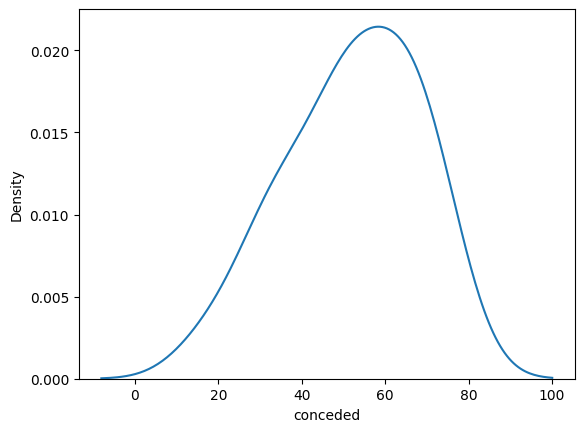

In [413]:
sns.kdeplot(result['conceded'])

In [443]:
result['scored'].describe()

count     20.00000
mean      52.15000
std       21.36469
min       34.00000
25%       40.00000
50%       45.50000
75%       51.25000
max      112.00000
Name: scored, dtype: float64

In [401]:
by_player_match[['player','team','degree_c','eigen_c','closeness_c','betweenness_c']].groupby(['player','team'],as_index=False).mean()

player             team  degree_c   eigen_c  \
0                   Abdoul Karim Yoda           Getafe  1.615385  0.210081   
1                  Abdoulaye Doucouré          Granada  1.370370  0.171872   
2           Abraham González Casanova         Espanyol  1.560000  0.189383   
3         Adalberto Peñaranda Maestre          Granada  1.592593  0.196177   
4    Aderllan Leandro de Jesus Santos         Valencia  1.655172  0.188509   
..                                ...              ...       ...       ...   
540              Íñigo Lekue Martínez    Athletic Club  1.875000  0.221813   
541            Íñigo Martínez Berridi    Real Sociedad  1.730769  0.211547   
542               Óliver Torres Muñoz  Atlético Madrid  1.833333  0.224816   
543          Óscar Esau Duarte Gaitán         Espanyol  1.440000  0.176130   
544             Óscar de Marcos Arana    Athletic Club  1.958333  0.225568   

     closeness_c  betweenness_c  
0       0.866667       0.002409  
1       0.750000       0.001477  
2       0.833333       0.002851  
3       0.818182       0.004457  
4       0.828571       0.029203  
..           ...            ...  
540     0.960000       0.007572  
541     0.866667       0.008227  
542     0.923077       0.009136  
543     0.781250       0.003070  
544     1.000000       0.016095  

[545 rows x 6 columns]

In [404]:
len(by_player_match['player'].unique())

538

In [436]:
merged_df = pd.merge(by_player_match[['player','team','degree_c','eigen_c','closeness_c','betweenness_c']].groupby(['player','team'],as_index=False).mean(), result, on=['team'], how='inner')
merged_df

player             team  degree_c   eigen_c  \
0                   Abdoul Karim Yoda           Getafe  1.615385  0.210081   
1                  Abdoulaye Doucouré          Granada  1.370370  0.171872   
2           Abraham González Casanova         Espanyol  1.560000  0.189383   
3         Adalberto Peñaranda Maestre          Granada  1.592593  0.196177   
4    Aderllan Leandro de Jesus Santos         Valencia  1.655172  0.188509   
..                                ...              ...       ...       ...   
540              Íñigo Lekue Martínez    Athletic Club  1.875000  0.221813   
541            Íñigo Martínez Berridi    Real Sociedad  1.730769  0.211547   
542               Óliver Torres Muñoz  Atlético Madrid  1.833333  0.224816   
543          Óscar Esau Duarte Gaitán         Espanyol  1.440000  0.176130   
544             Óscar de Marcos Arana    Athletic Club  1.958333  0.225568   

     closeness_c  betweenness_c  scored  conceded  
0       0.866667       0.002409    37.0      67.0  
1       0.750000       0.001477    46.0      69.0  
2       0.833333       0.002851    40.0      74.0  
3       0.818182       0.004457    46.0      69.0  
4       0.828571       0.029203    46.0      48.0  
..           ...            ...     ...       ...  
540     0.960000       0.007572    58.0      45.0  
541     0.866667       0.008227    45.0      48.0  
542     0.923077       0.009136    63.0      18.0  
543     0.781250       0.003070    40.0      74.0  
544     1.000000       0.016095    58.0      45.0  

[545 rows x 8 columns]

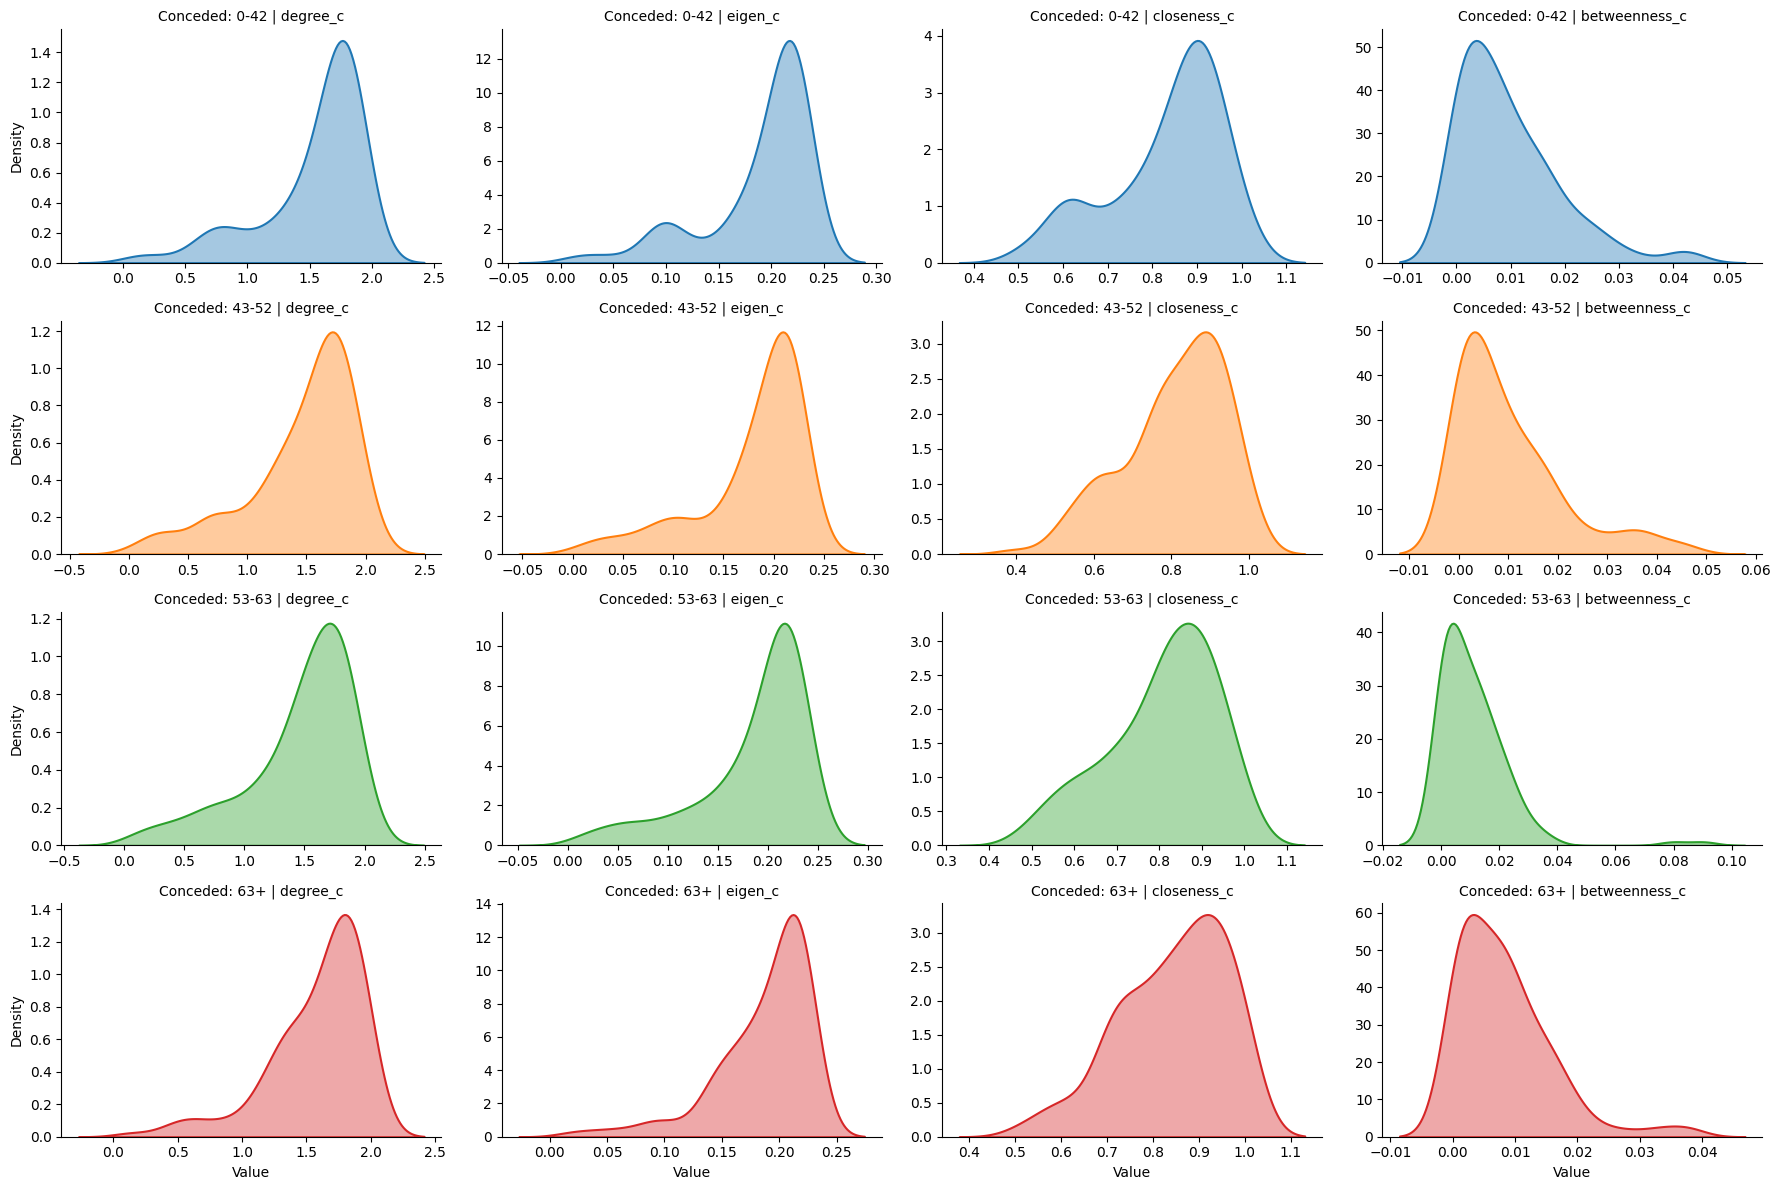

In [441]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics = ['degree_c', 'eigen_c', 'closeness_c', 'betweenness_c']

# Bin the conceded goals into 4 categories
merged_df['conceded_category'] = pd.cut(
    merged_df['conceded'],
    bins=[0, 42, 52, 63, float('inf')],  # Define bins for conceded goals
    labels=['0-42', '43-52', '53-63', '63+'],  # Labels for the bins
    right=True
)

# Melt the DataFrame to create a "long" format for plotting
melted_df = merged_df.melt(
    id_vars=['team', 'conceded_category'],  # Include team and conceded categories
    value_vars=metrics,  # Metrics to unpivot
    var_name='metric',  # New column for metric names
    value_name='value'  # New column for metric values
)

# Define a custom color palette for categories
category_palette = {
    '0-42': '#1f77b4',  # Blue
    '43-52': '#ff7f0e',  # Orange
    '53-63': '#2ca02c',  # Green
    '63+': '#d62728'  # Red
}

# Create a FacetGrid for 4-row, 4-column layout
g = sns.FacetGrid(
    melted_df,
    row='conceded_category',  # Rows represent conceded categories
    col='metric',  # Columns represent metrics
    sharex=False,  # Allow different x-axis ranges for each metric
    sharey=False,  # Allow different y-axis ranges for each metric
    height=3,
    aspect=1.5  # Control the aspect ratio of the plots
)

# Custom plotting function to assign colors manually
def plot_kde(data, **kwargs):
    category = data['conceded_category'].iloc[0]  # Get the current category
    color = category_palette[str(category)]  # Map the category to a color
    sns.kdeplot(data=data, x='value', fill=True, alpha=0.4, linewidth=1.5, color=color)

# Map the custom plotting function
g.map_dataframe(plot_kde)

# Add titles and adjust layout
g.set_titles(row_template="Conceded: {row_name}", col_template="{col_name}")
g.set_axis_labels("Value", "Density")
g.tight_layout()

# Show the plot
plt.show()


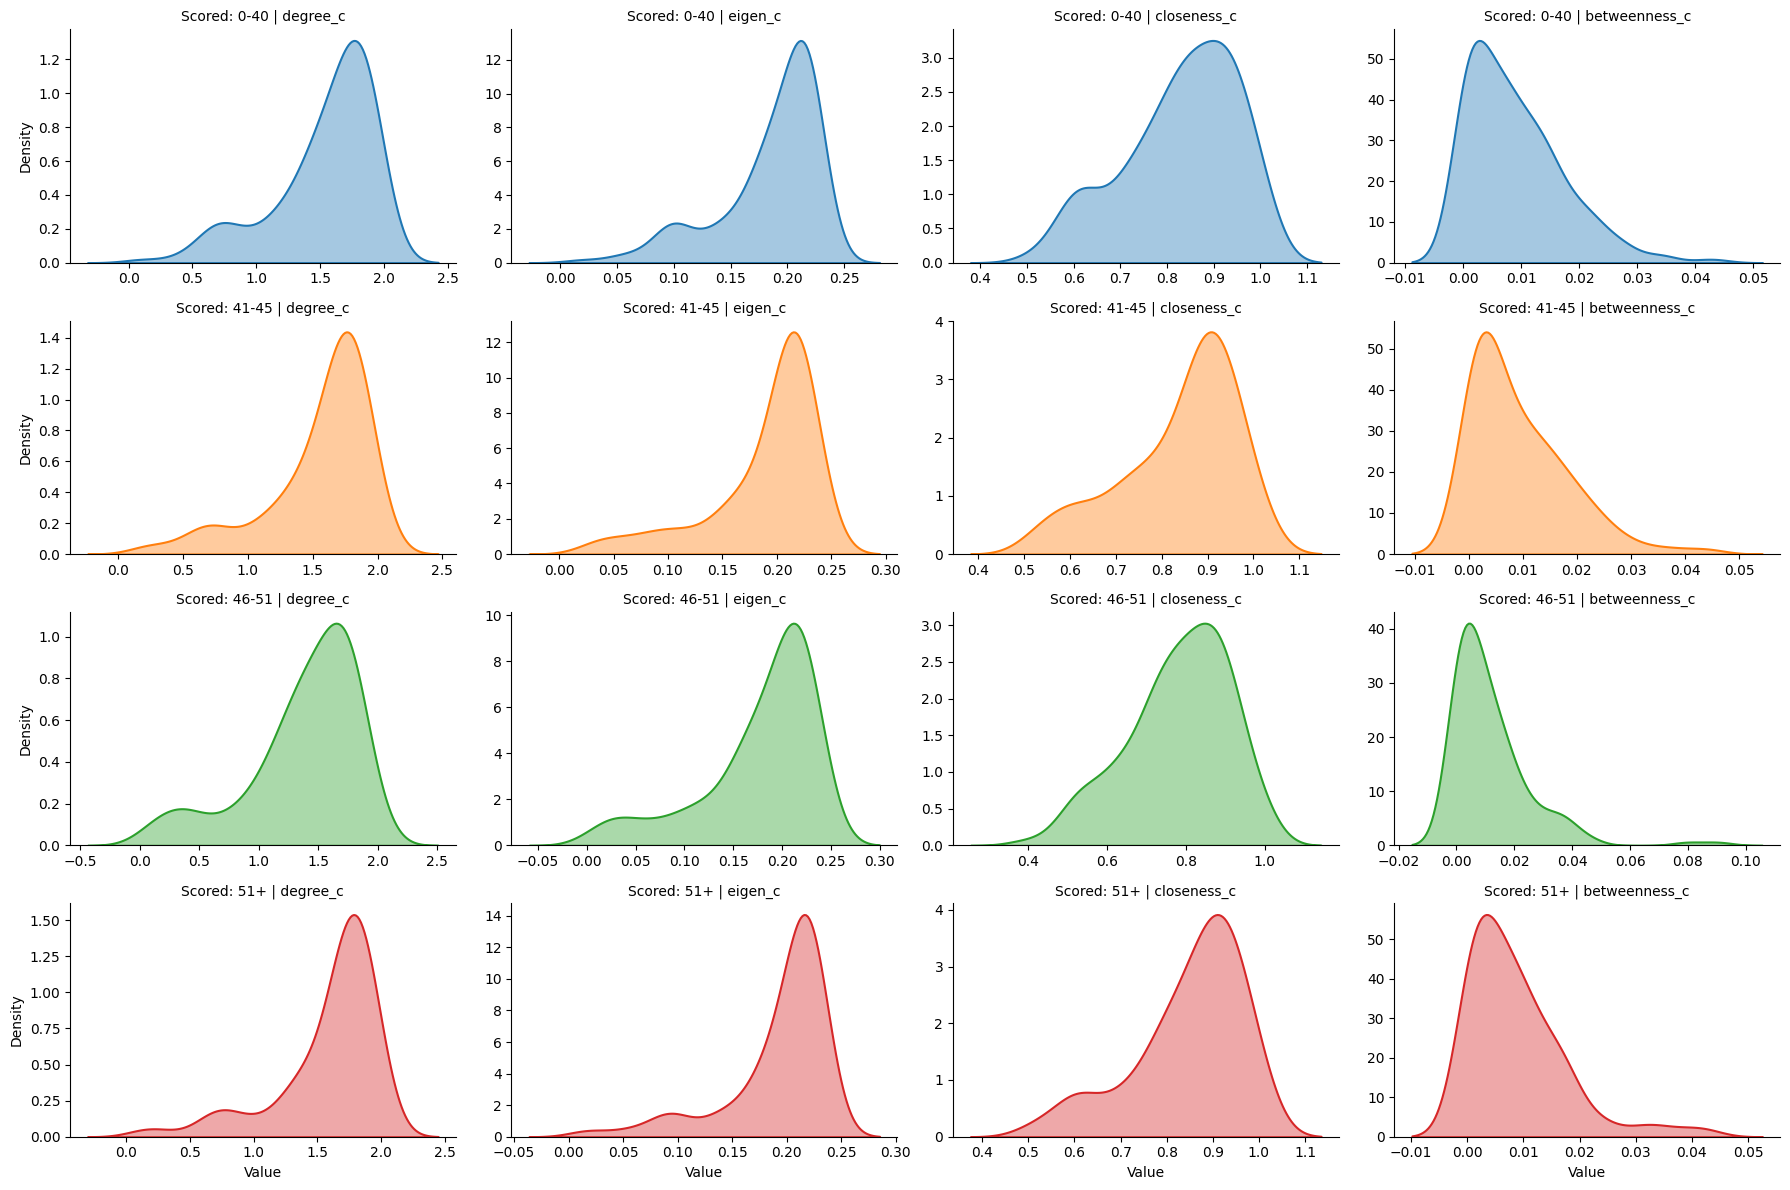

In [445]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics = ['degree_c', 'eigen_c', 'closeness_c', 'betweenness_c']

# Bin the conceded goals into 4 categories
merged_df['scored_category'] = pd.cut(
    merged_df['scored'],
    bins=[0, 40, 45, 51, float('inf')],  # Define bins for conceded goals
    labels=['0-40', '41-45', '46-51', '51+'],  # Labels for the bins
    right=True
)

# Melt the DataFrame to create a "long" format for plotting
melted_df = merged_df.melt(
    id_vars=['team', 'scored_category'],  # Include team and conceded categories
    value_vars=metrics,  # Metrics to unpivot
    var_name='metric',  # New column for metric names
    value_name='value'  # New column for metric values
)

# Define a custom color palette for categories
category_palette = {
    '0-40': '#1f77b4',  # Blue
    '41-45': '#ff7f0e',  # Orange
    '46-51': '#2ca02c',  # Green
    '51+': '#d62728'  # Red
}

# Create a FacetGrid for 4-row, 4-column layout
g = sns.FacetGrid(
    melted_df,
    row='scored_category',  # Rows represent conceded categories
    col='metric',  # Columns represent metrics
    sharex=False,  # Allow different x-axis ranges for each metric
    sharey=False,  # Allow different y-axis ranges for each metric
    height=3,
    aspect=1.5  # Control the aspect ratio of the plots
)

# Custom plotting function to assign colors manually
def plot_kde(data, **kwargs):
    category = data['scored_category'].iloc[0]  # Get the current category
    color = category_palette[str(category)]  # Map the category to a color
    sns.kdeplot(data=data, x='value', fill=True, alpha=0.4, linewidth=1.5, color=color)

# Map the custom plotting function
g.map_dataframe(plot_kde)

# Add titles and adjust layout
g.set_titles(row_template="Scored: {row_name}", col_template="{col_name}")
g.set_axis_labels("Value", "Density")
g.tight_layout()

# Show the plot
plt.show()
